# Group C

## Group members: Eloise Habek, Luca Jimenez, Zoe Monnard, Valentina Pucci

**Part 2 - Generalization across subjects**

Importing all the necessary libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.io import loadmat

import random
random.seed(42)

1. Consider now 27 subjects (only exercise set 1 as in part 1). Perform the same preprocessing pipeline as in part 1

In [2]:
fs = 100

#agregated_data is a dictionary with the key being the subject number and the value #a tuple with 3 data frame (emg,stimulus,repetition)
agregated_data = {}
num_subjects = 27
for i in range(num_subjects):
    #data is already rectified and bandpass filtered
    path = f"DB/s{i+1}/S{i+1}_A1_E1.mat"
    data = loadmat(path)
    emg = data["emg"].copy()
    stimulus = data["restimulus"] 
    repetition = data["rerepetition"] 
    agregated_data[i+1] = (emg,stimulus,repetition)
    

In [3]:
#these values are the same for all samples
emg,stimulus,repetition = agregated_data[1]
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

In [4]:
def window_envelop(emg, stimulus, repetition):
    """Define emg_windows and emg_envelops with moving average"""

    #0.25 × Sample frequency (SF) => paper
    mov_mean_length = int(0.25*fs)
    mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 
    return emg_windows, emg_envelopes

In [5]:
def plot_window_envelope(emg_windows,emg_envelopes,remove_channels,stim,rep,scaled = False):
    plt.close("all")
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=scaled, sharey=scaled)
    ax = ax.ravel()

    number_of_emg_channels = emg.shape[-1]
    # plot Rectified EMG signal but skipping channel 4
    for channel_idx in range(number_of_emg_channels): 
        if channel_idx in remove_channels:
            continue
        ax[channel_idx].plot(emg_windows[stim][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle("Rectified EMG signal")

    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=scaled, sharey=scaled)
    ax = ax.ravel()
    for channel_idx in range(number_of_emg_channels): 
        if channel_idx in remove_channels:
            continue
        ax[channel_idx].plot(emg_envelopes[stim][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle("Envelopes of the EMG signal")

In [6]:
def average_activation_per_channel(emg_envelopes):
    emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            #mean across time for each channel
            emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)
    return emg_average_activations

In [7]:
def plot_avg_activation(emg_average_activations,sub):
    fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle(f"Subject {sub}", fontsize=16) 
    ax = ax.ravel()

    for stimuli_idx in range(n_stimuli):
        sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
        ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG channel")
    plt.show()
    

In [8]:
windows_envelopes_per_subject = {}
for sub,data in agregated_data.items():
    windows_envelopes_per_subject[sub] = window_envelop(data[0],data[1],data[2])

Checking out the window enveloped signal for a specific repetition of a stimuli (stim=0, rep=1) from subject 1

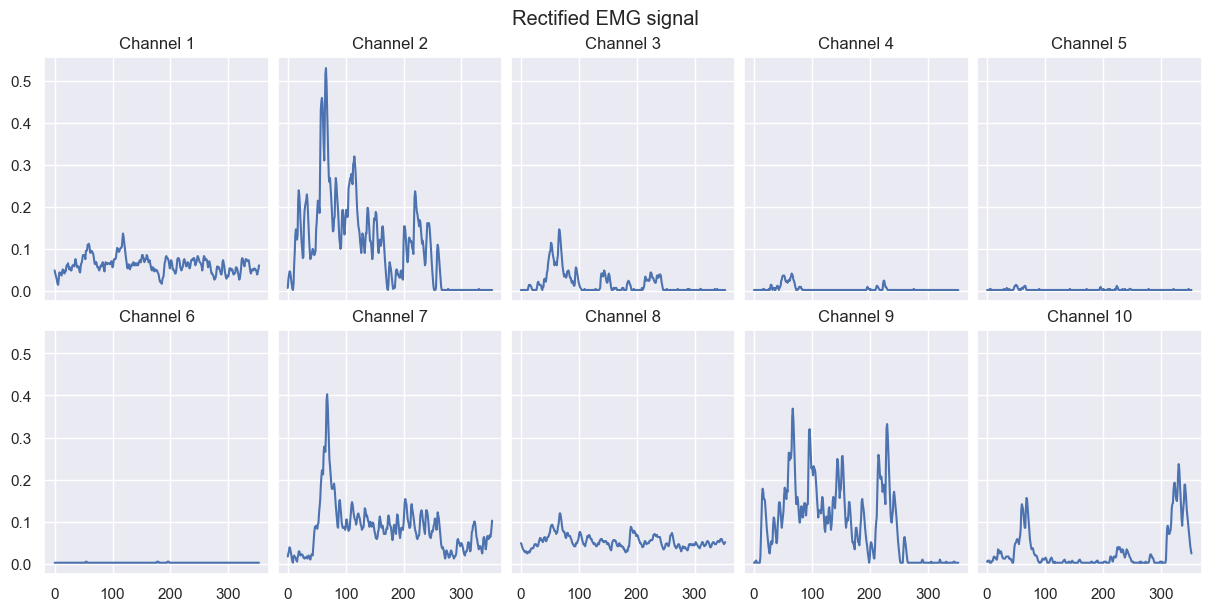

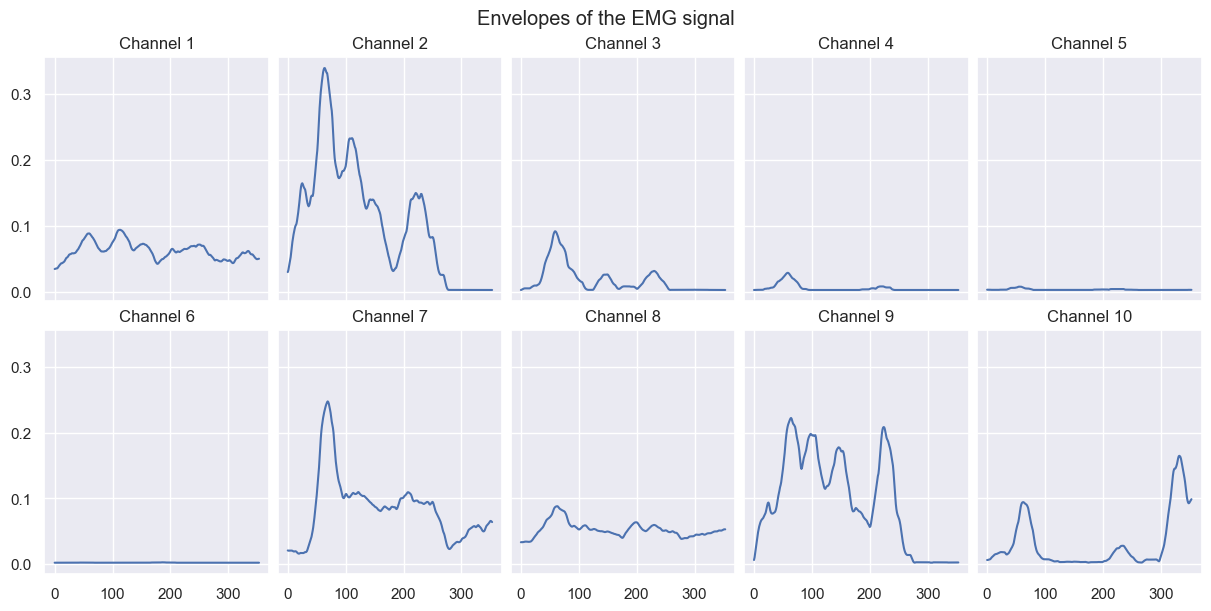

In [9]:
plot_window_envelope(windows_envelopes_per_subject[1][0],windows_envelopes_per_subject[1][1],[],0,1,scaled=True)

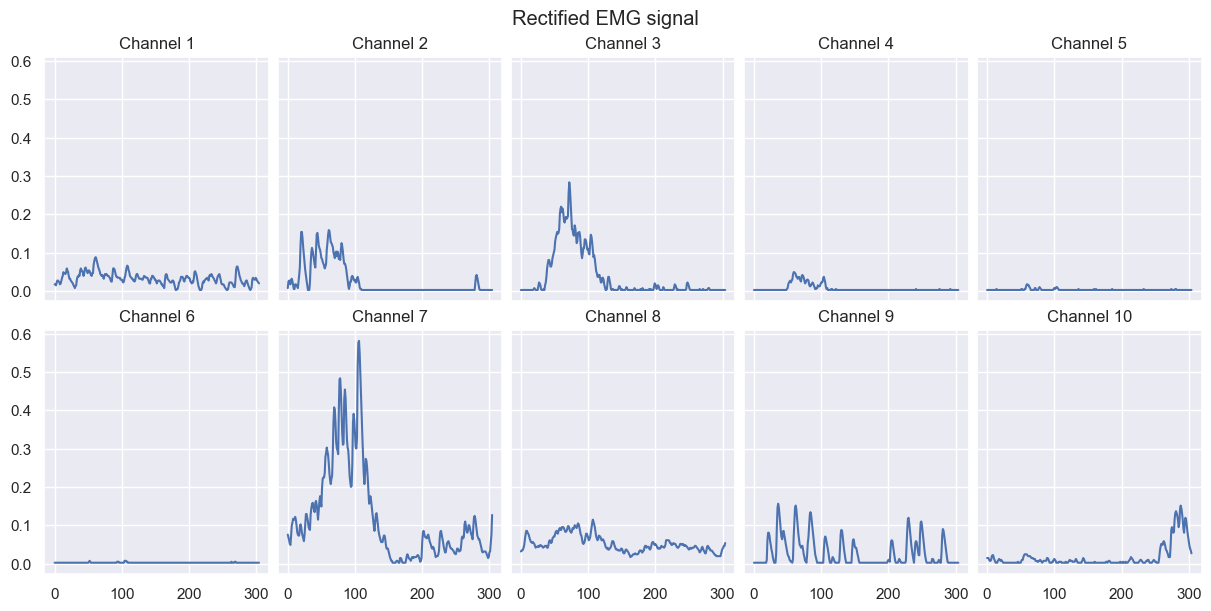

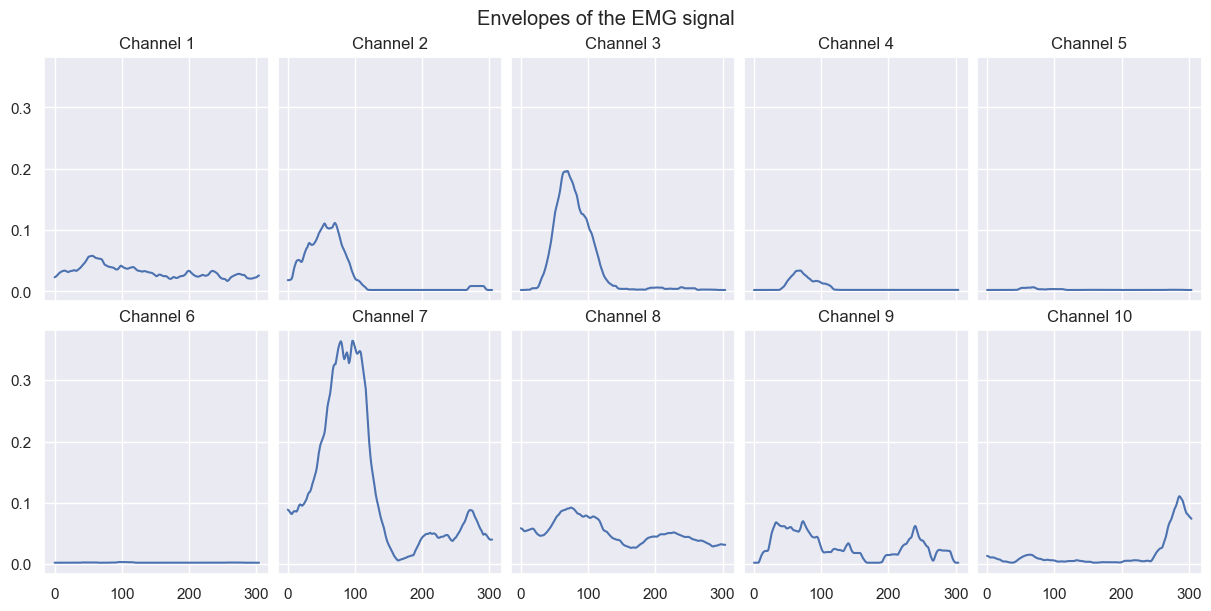

In [10]:
plot_window_envelope(windows_envelopes_per_subject[1][0],windows_envelopes_per_subject[1][1],[],0,0,scaled=True)

In [11]:
avg_activation_per_subject = {}
for sub,data in windows_envelopes_per_subject.items():
    avg_activation_per_subject[sub] = average_activation_per_channel(data[1])

In [12]:
def check_for_constant_channels(emg):
    indices = [index + 1 for index, value in enumerate(emg) if np.all(value == emg[0])]
    return indices


def check_subject(emg_average_activations):
    # Iterate through stimuli and repetitions
    for stimuli_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            # Extract the channel activations for the current stimulus and repetition
            data_cropped = emg_average_activations[:, stimuli_idx, rep_idx]  # Shape: (n_channels,)
            # Check for constant channels
            indices = check_for_constant_channels(data_cropped)
            
            # If constant channels are found, print the details
            if len(indices) > 1:
                print(f"Stimulus: {stimuli_idx + 1}, Repetition: {rep_idx + 1}")
                print(f"Constant channels: {indices}")

In [13]:
for sub,data in avg_activation_per_subject.items():
    print(f"Subject {sub}, constant channel checking...")
    check_subject(data)

Subject 1, constant channel checking...
Subject 2, constant channel checking...
Subject 3, constant channel checking...
Subject 4, constant channel checking...
Subject 5, constant channel checking...
Subject 6, constant channel checking...
Subject 7, constant channel checking...
Subject 8, constant channel checking...
Subject 9, constant channel checking...
Subject 10, constant channel checking...
Subject 11, constant channel checking...
Subject 12, constant channel checking...
Subject 13, constant channel checking...
Subject 14, constant channel checking...
Subject 15, constant channel checking...
Subject 16, constant channel checking...
Subject 17, constant channel checking...
Subject 18, constant channel checking...
Subject 19, constant channel checking...
Subject 20, constant channel checking...
Subject 21, constant channel checking...
Subject 22, constant channel checking...
Subject 23, constant channel checking...
Subject 24, constant channel checking...
Subject 25, constant chan

In [14]:
def trial_to_exclude(emg_average_activations, stimuli_idx, threshold_factor=1.5):

    # (shape: n_channels x n_repetitions)
    data_from_stimuli = emg_average_activations[:, stimuli_idx, :]
    
    median_pattern = np.median(data_from_stimuli, axis=1)
    median_pattern_r = median_pattern[:, np.newaxis]  # Shape becomes (a, 1)
    distances = np.sqrt((data_from_stimuli - median_pattern_r) ** 2)
    # distances shape : channel x repetition
    Q1 = np.percentile(distances, 25, axis=1)  # shape: (n_channels,)
    Q3 = np.percentile(distances, 75, axis=1)  # shape: (n_channels,)
    
    IQR = Q3 - Q1
    # Define the threshold for outliers
    lower_bound = Q1 - threshold_factor * IQR #(channel,)
    upper_bound = Q3 + threshold_factor * IQR #(channel,)

    #if for one channel there is an outlier repetition then we want to remove that trial (stimulus x repetition) - print out channel x repetition
    
    outlier_mask = (distances < lower_bound[:, np.newaxis]) | (distances > upper_bound[:, np.newaxis])  # shape: (n_channels, n_repetitions)

    # Collect the trials (channel, repetition) where outliers are present
    trials_to_exclude = np.argwhere(outlier_mask)  # shape: (n_outliers, 2)
    return trials_to_exclude.tolist()  # Convert to list of tuples

Analysis of which trails would fall into the category of outlier

In [15]:
for sub,data in avg_activation_per_subject.items():
    for stimuli_idx in range(n_stimuli):
        trials = trial_to_exclude(data,stimuli_idx, threshold_factor=8)
        rep = set([a[1] for a in trials])
        if len(rep)>0:
            print(f"Subject {sub}")
            print(f"Stimulus: {stimuli_idx+1}")
            print(f"Outlier trials: {rep}")

Subject 1
Stimulus: 1
Outlier trials: {3}
Subject 1
Stimulus: 2
Outlier trials: {0, 6}
Subject 1
Stimulus: 3
Outlier trials: {0, 6}
Subject 1
Stimulus: 5
Outlier trials: {2}
Subject 1
Stimulus: 6
Outlier trials: {0, 6}
Subject 1
Stimulus: 8
Outlier trials: {0, 1}
Subject 1
Stimulus: 10
Outlier trials: {2}
Subject 1
Stimulus: 11
Outlier trials: {0, 3}
Subject 1
Stimulus: 12
Outlier trials: {0, 9}
Subject 2
Stimulus: 8
Outlier trials: {4}
Subject 2
Stimulus: 10
Outlier trials: {0}
Subject 3
Stimulus: 3
Outlier trials: {0, 2}
Subject 3
Stimulus: 6
Outlier trials: {2, 3}
Subject 3
Stimulus: 9
Outlier trials: {1}
Subject 3
Stimulus: 12
Outlier trials: {2}
Subject 4
Stimulus: 8
Outlier trials: {1}
Subject 4
Stimulus: 10
Outlier trials: {0}
Subject 5
Stimulus: 12
Outlier trials: {8}
Subject 6
Stimulus: 2
Outlier trials: {3}
Subject 6
Stimulus: 4
Outlier trials: {0}
Subject 6
Stimulus: 7
Outlier trials: {0}
Subject 6
Stimulus: 8
Outlier trials: {8}
Subject 7
Stimulus: 3
Outlier trials: {2}
Sub

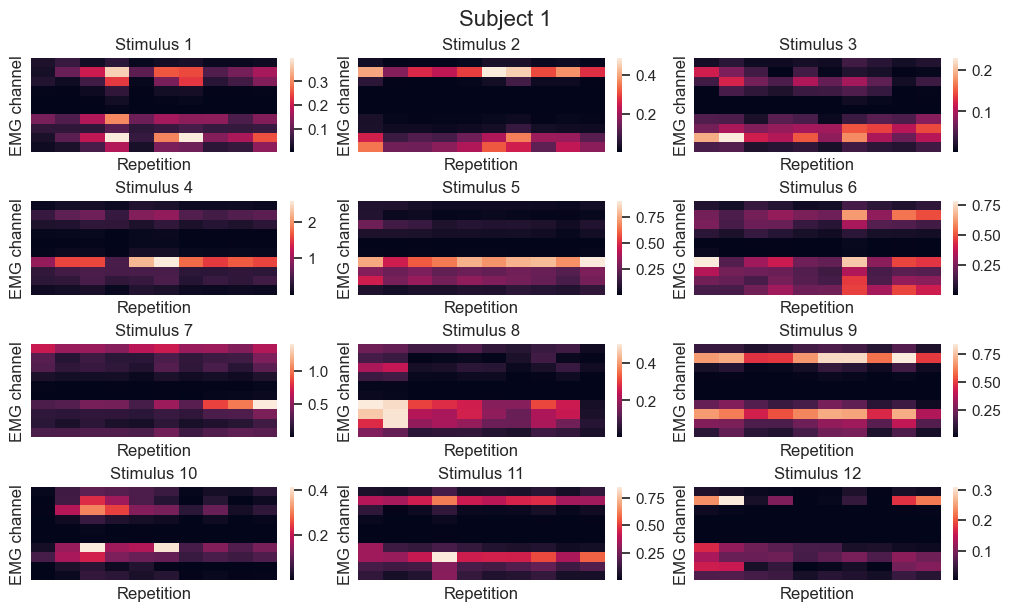

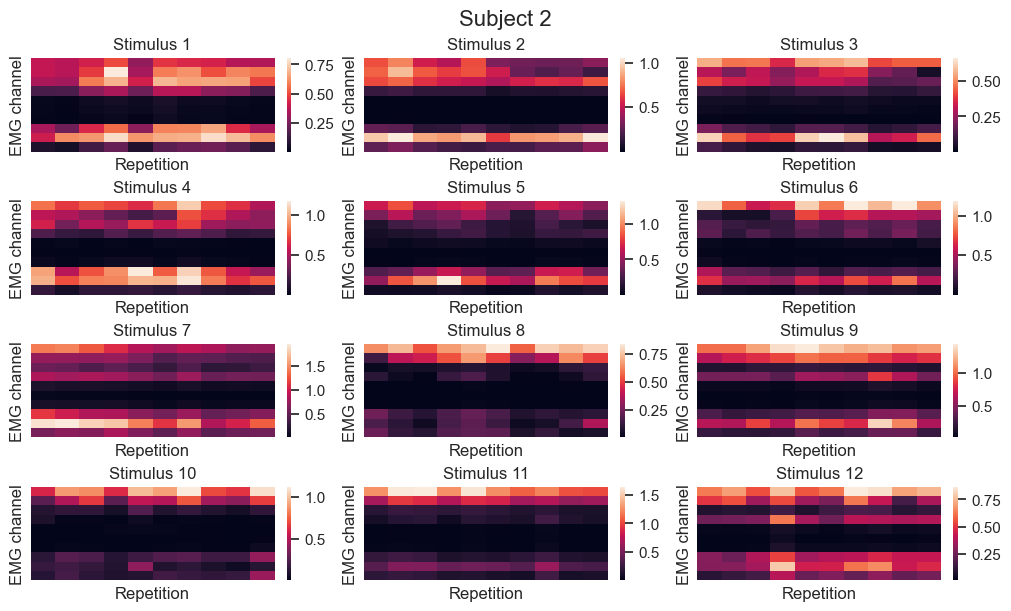

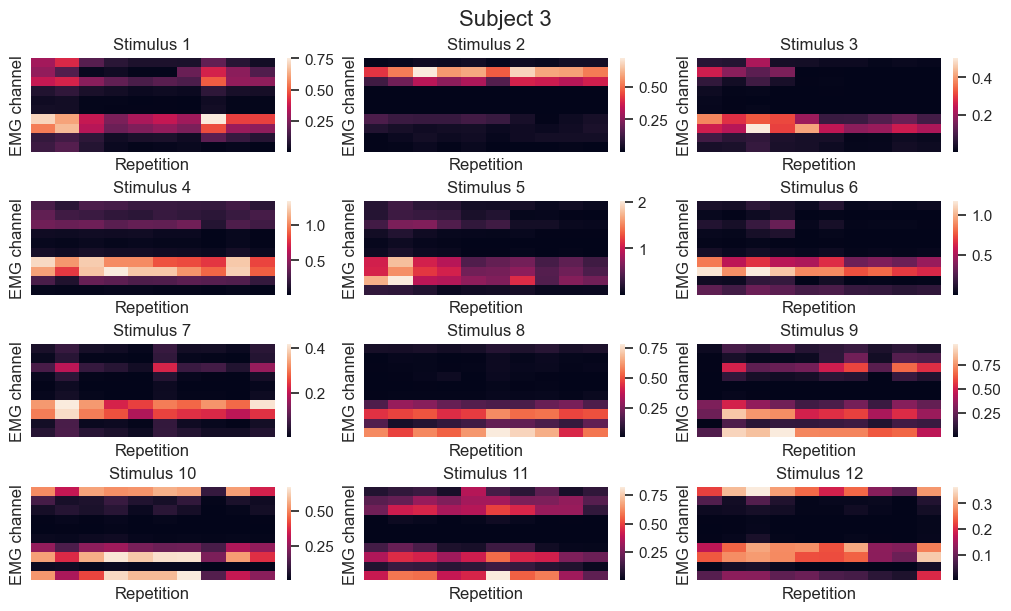

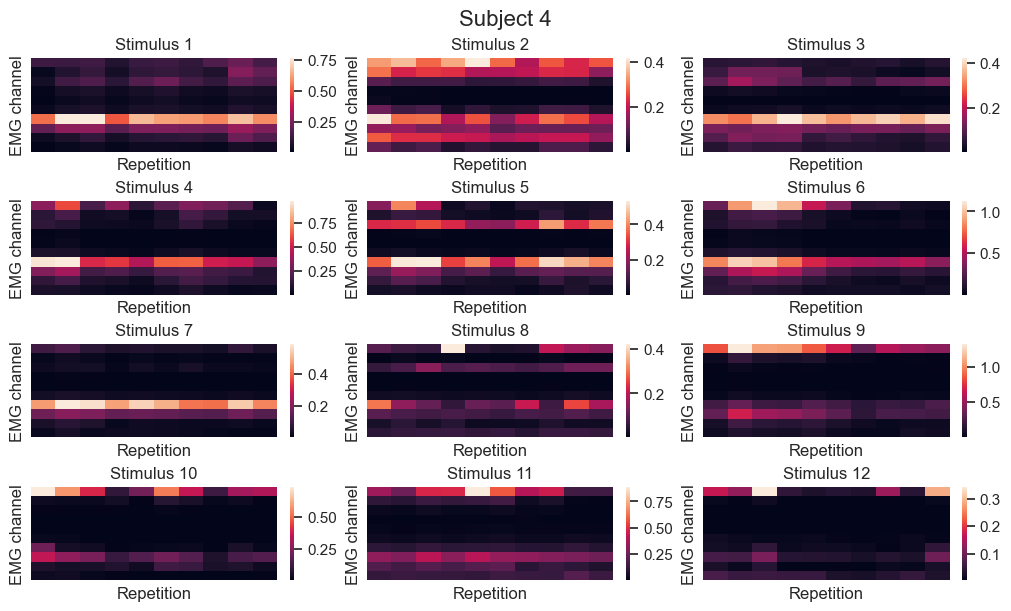

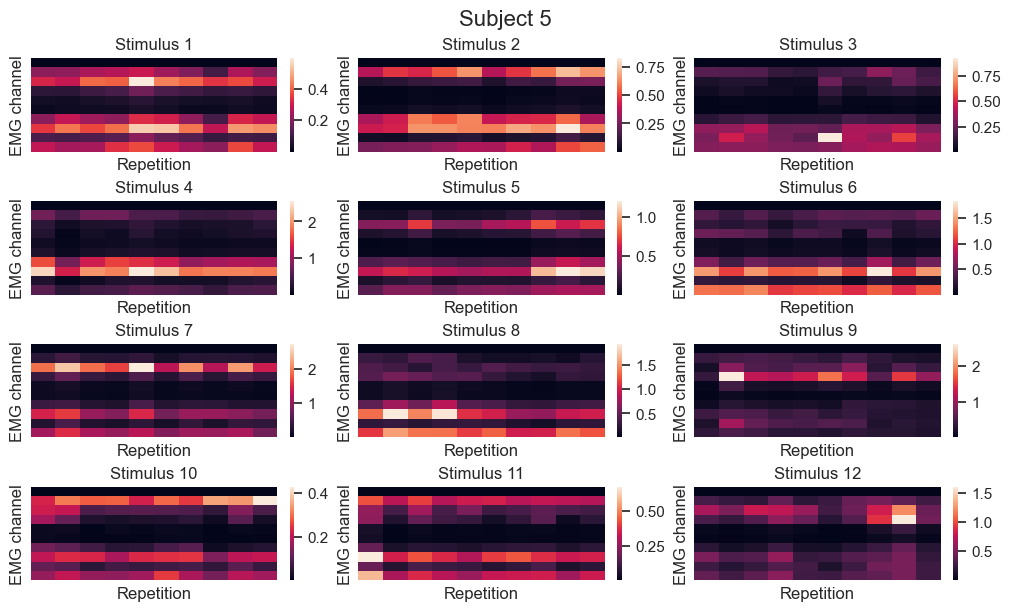

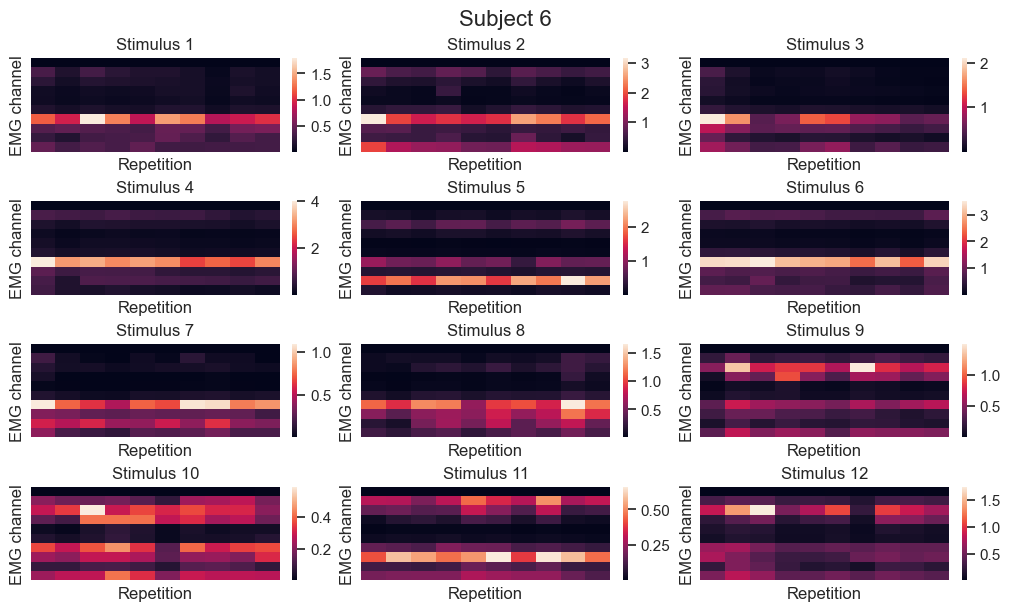

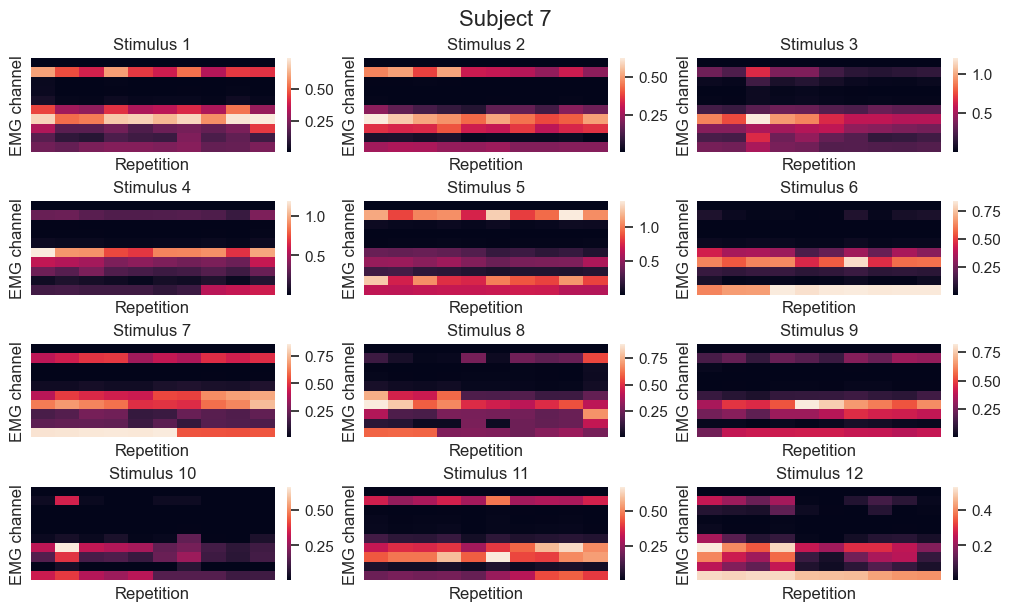

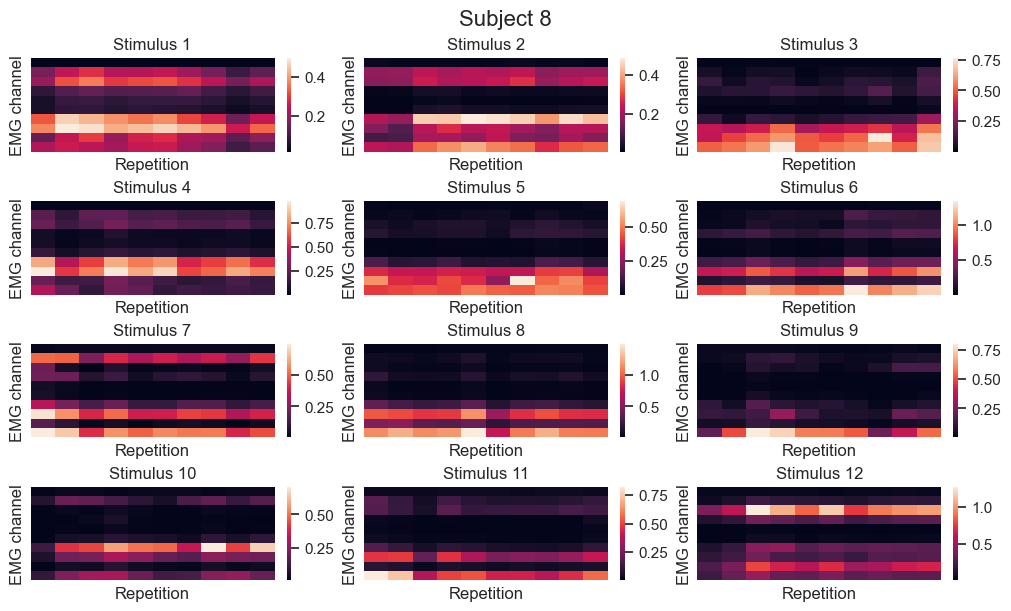

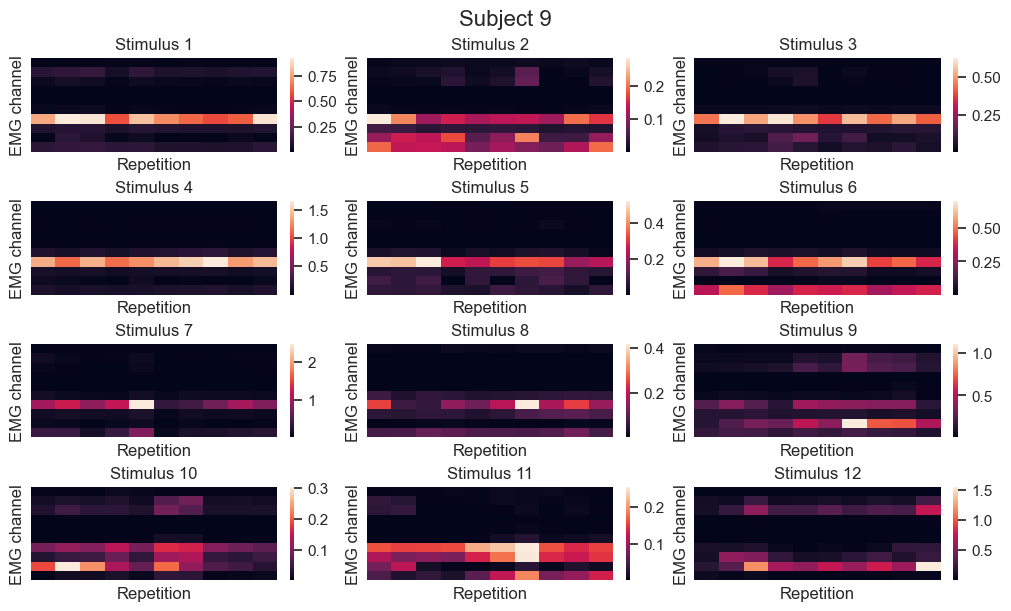

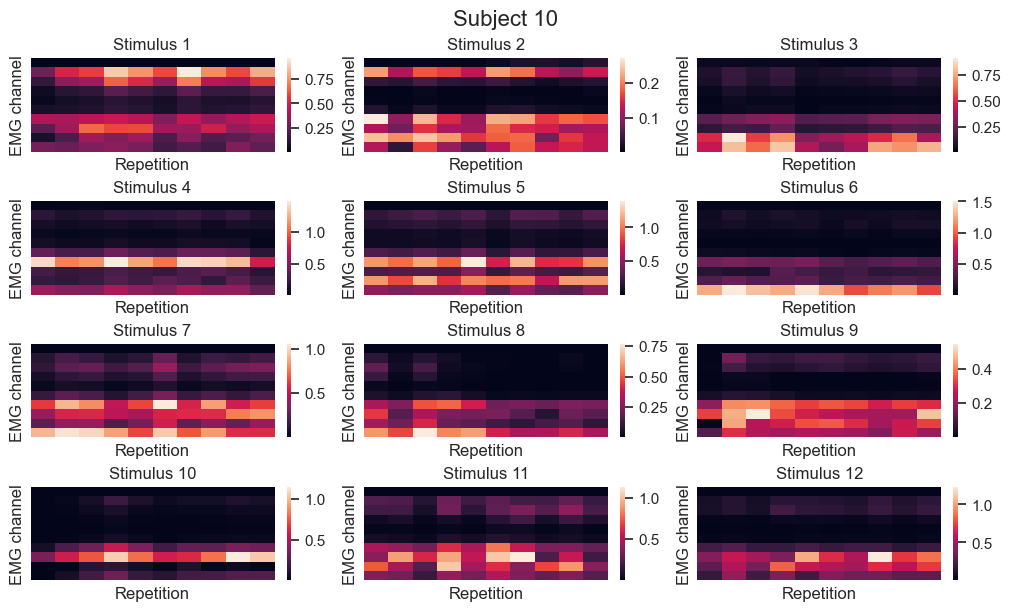

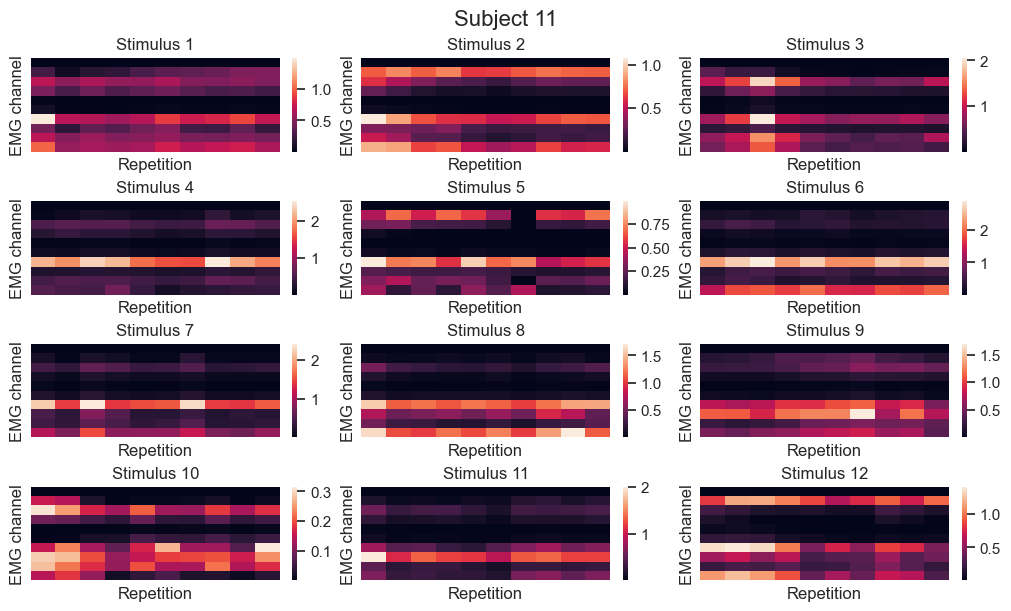

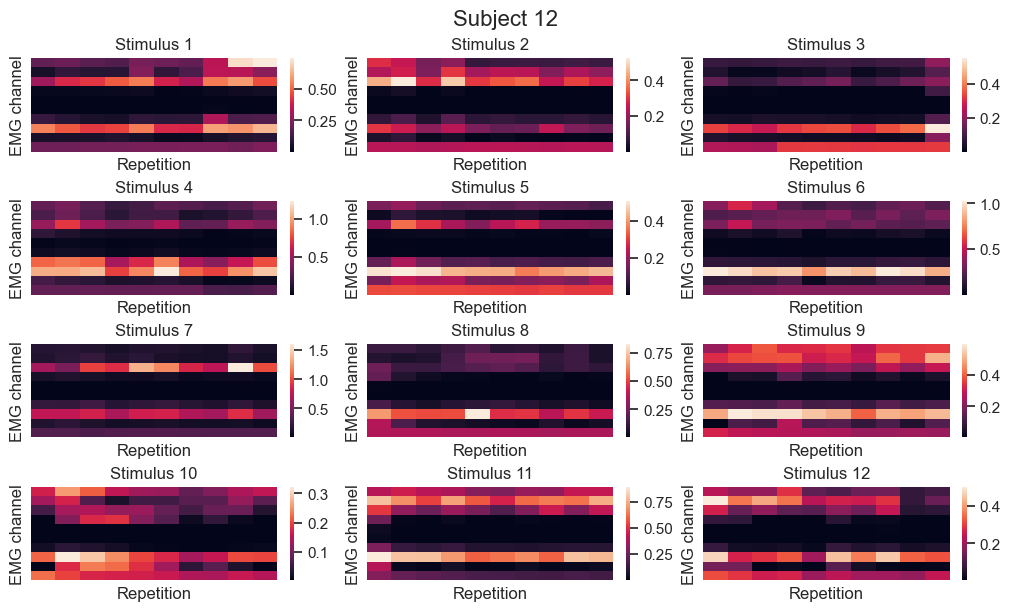

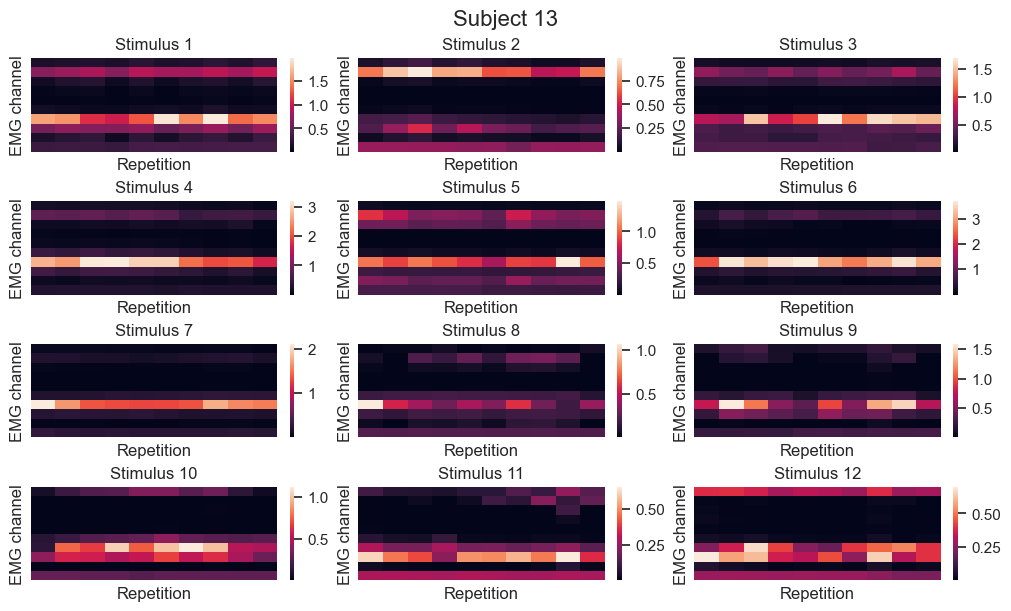

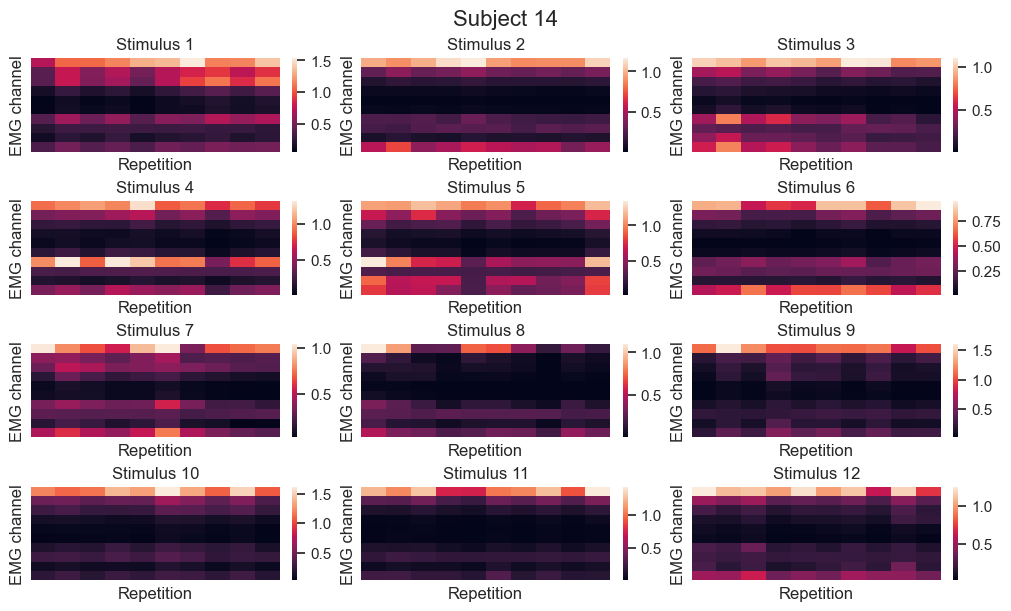

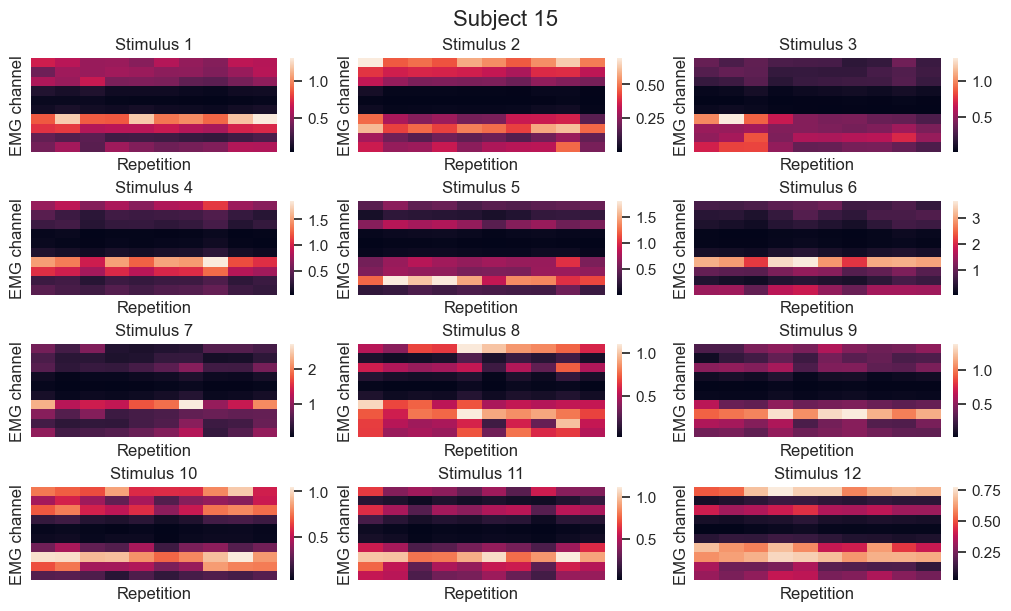

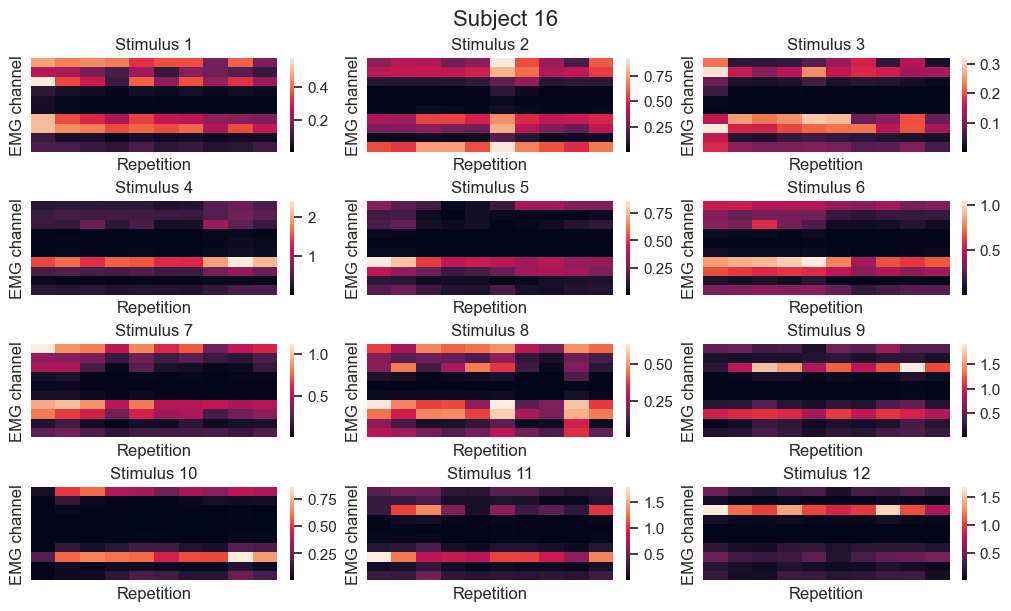

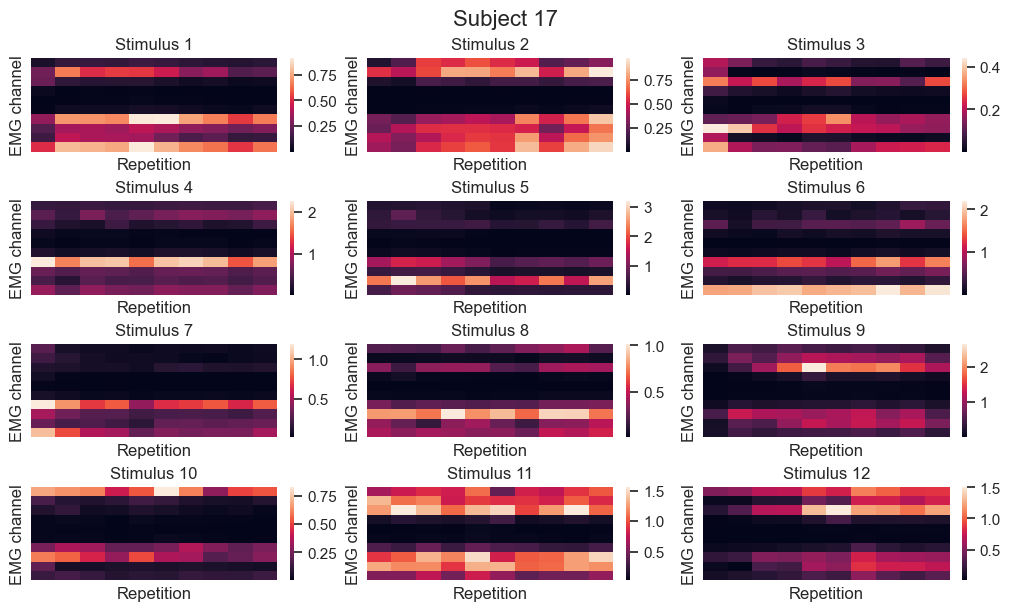

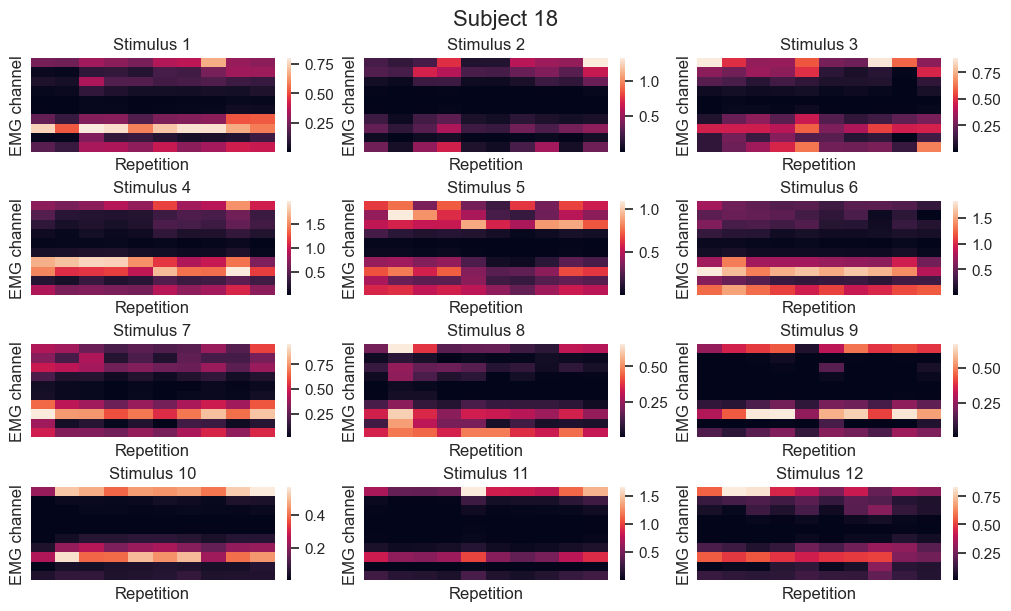

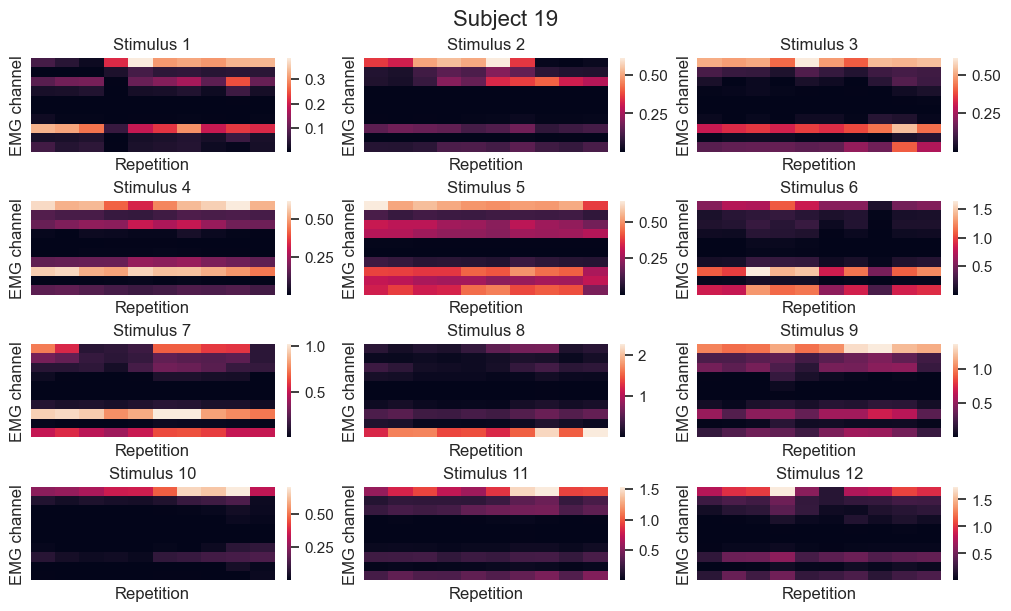

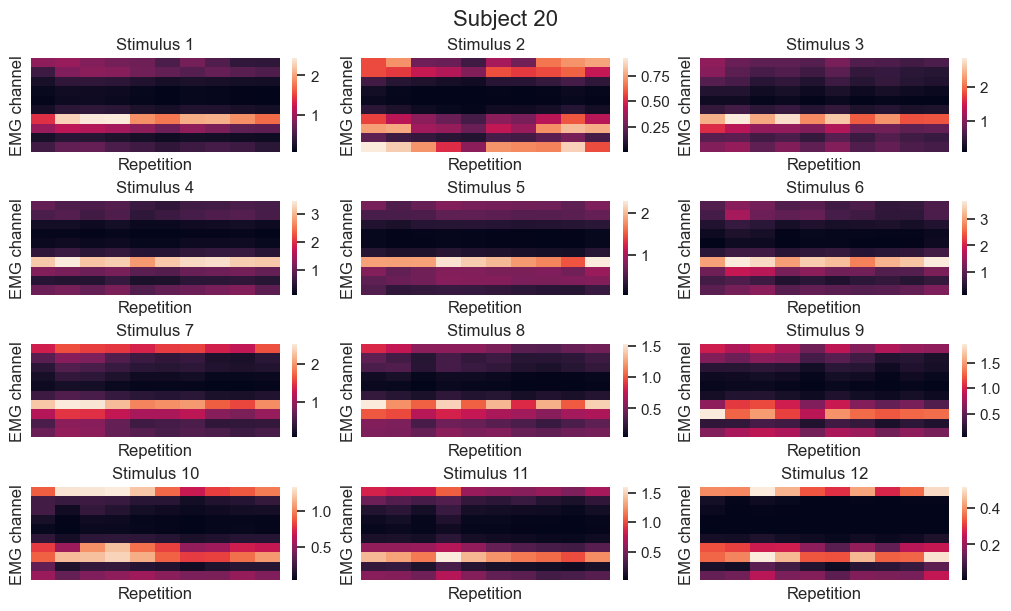

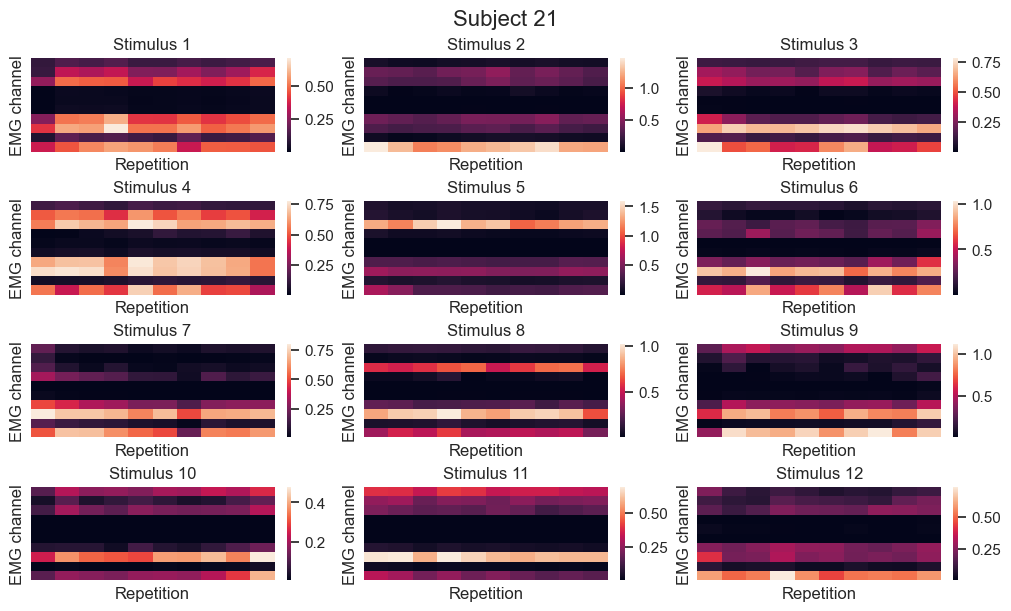

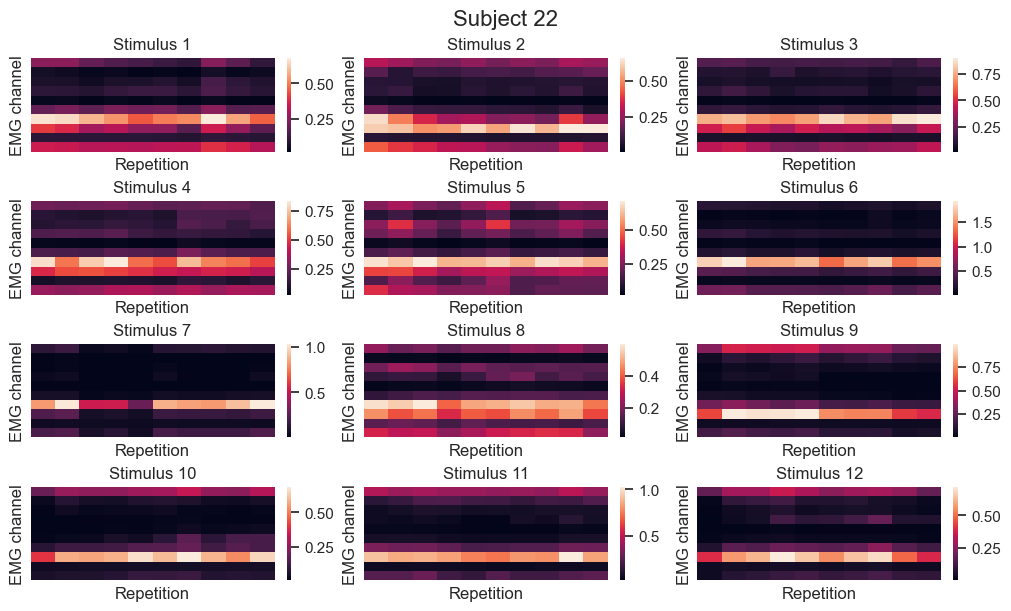

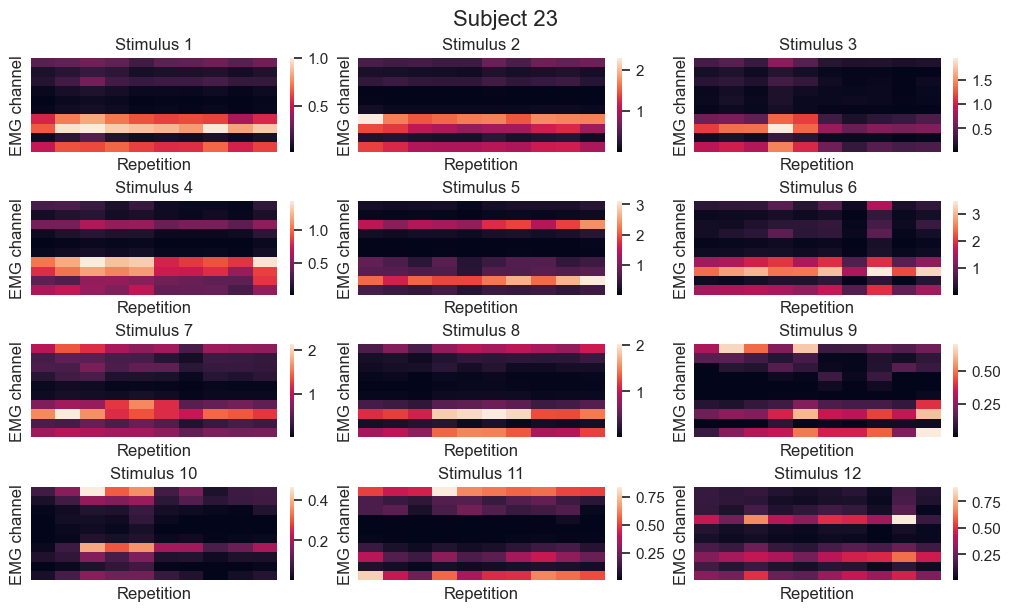

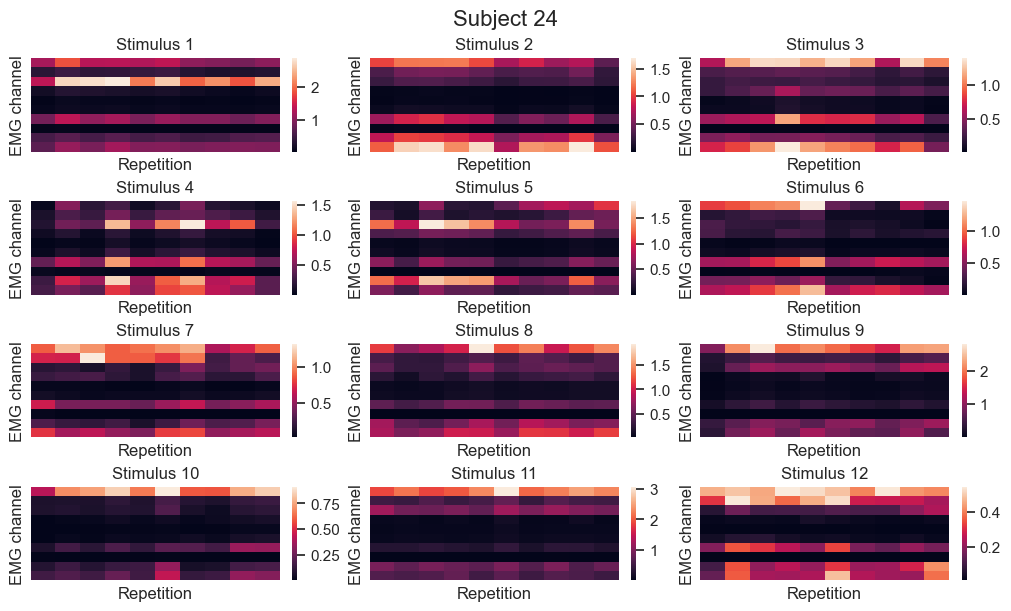

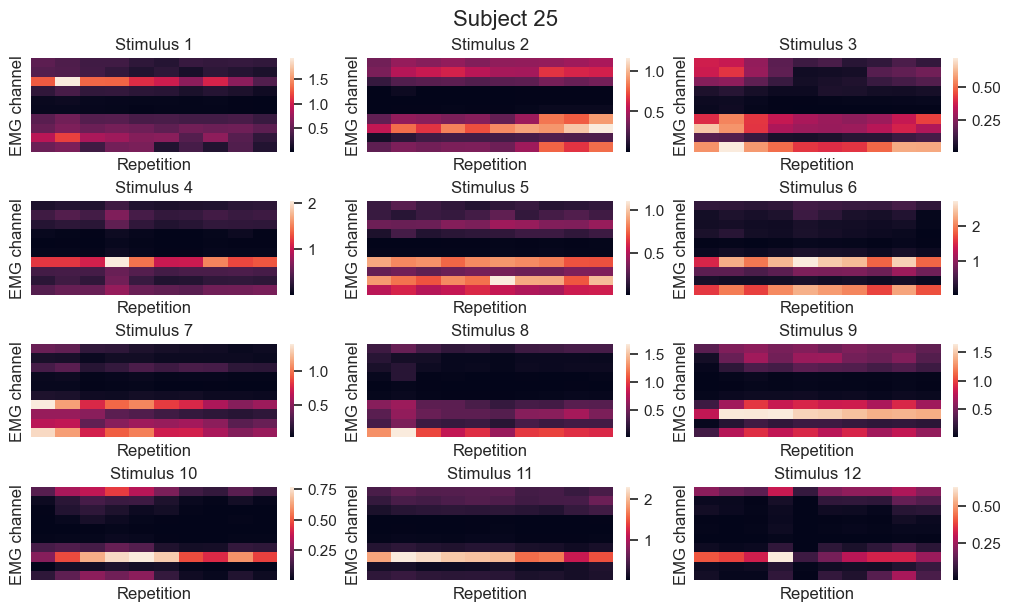

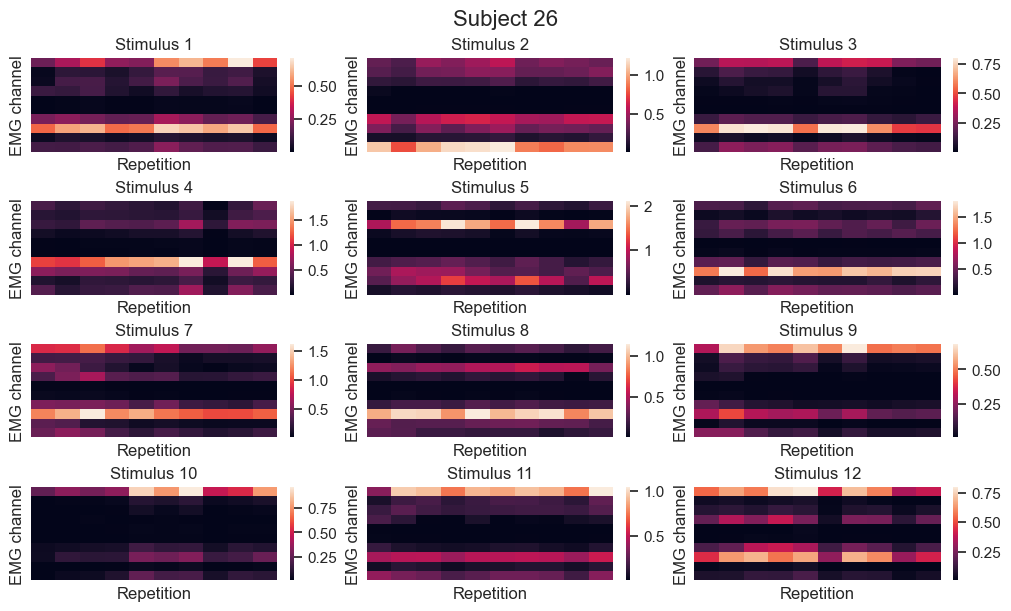

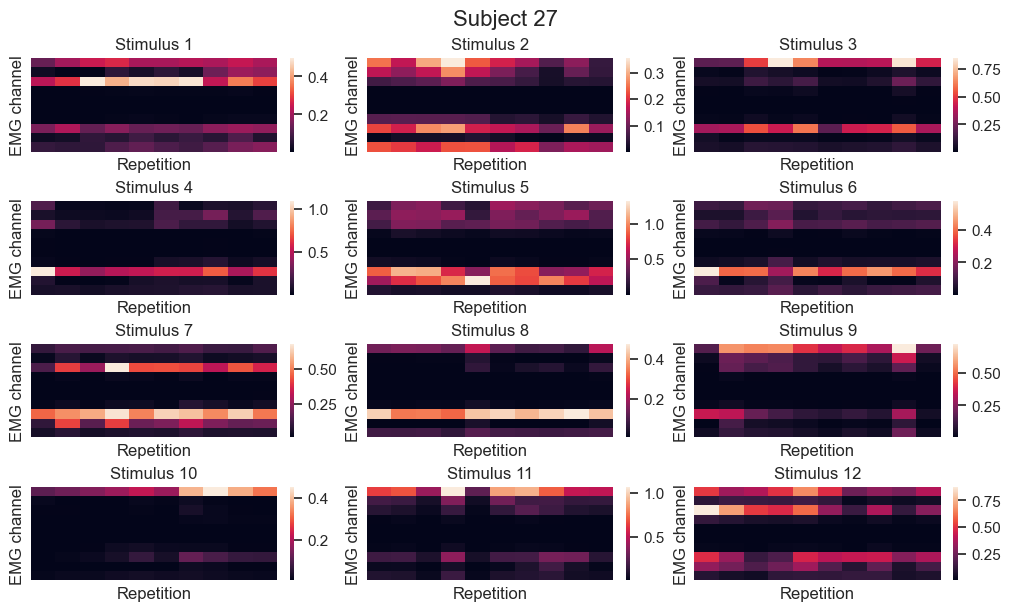

In [16]:
for sub,data in avg_activation_per_subject.items():
    plot_avg_activation(data,sub)

2. Extract the same set of features. Now look at the values of those features across the different subjects. Are there any similarity/discrepancies between the subjects?

In [17]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1 # 10
    n_repetitions = np.unique(repetition).size - 1 # 12
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions #120
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1] #10
    
    # features is a list of functions that will be applied to the EMG data to extract features
    # Calculate the total number of features by summing the number of channels for each feature
    # Each feature will generate n_channels values per sample.
    # For example, if features = [mean_absolute_value, waveform_length], n_features = 2 * n_channels
    
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features)) # 120 rows, features.len * n_channels columns (if I use 6 features, the matrix is 120x60)
    labels = np.zeros(n_samples) # 120 rows
    current_sample_index = 0
    
    # one label per sample, each sample is a repetition of a stimulus (trial) 
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
     # Return the constructed dataset and corresponding labels
    return dataset, labels

In [18]:
agregated_data[1][0].shape

(101014, 10)

In [19]:
# Cepstral Coefficients (Ceps)
from scipy.fftpack import dct

def cepstral_coefficients(x, num_coeffs=1):
    """Compute Cepstral Coefficients using DCT of log-spectrum."""
    ceps = np.zeros((x.shape[1], num_coeffs))
    for ch in range(x.shape[1]):
        spectrum = np.abs(np.fft.fft(x[:, ch]))
        log_spectrum = np.log1p(spectrum[:len(spectrum)//2])
        ceps[ch, :] = dct(log_spectrum, type=2, norm='ortho')[:num_coeffs]
    return ceps

# Mean Absolute Value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms  = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl  = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum(np.diff(np.sign(np.diff(x, axis=0)), axis=0) != 0, axis=0)
# Cepstral Coefficients (Ceps)
ceps = lambda x: cepstral_coefficients(x.reshape(-1, 1), num_coeffs=12).flatten()[0] # 12 coefficients, take the first one

#To compute these features across all channels, you can loop:

#agregated_data is a dictionary with the key being the subject number and the value #a tuple with 3 data frame (emg,stimulus,repetition)

#this part of the code is for the analysis of difference between samples in features
features = {}

for sub, data in agregated_data.items():
    features[sub] = {}
    for i in range(n_channels):
        channel_data = data[0][:, i]
        #calculate feature across all stimulus and repetitions
        features[sub][i] = {
            "MAV": float(mav(channel_data)),
            "STD": float(std(channel_data)),
            "MaxAV": float(maxav(channel_data)),
            "RMS": float(rms(channel_data)),
            "WL": float(wl(channel_data)),
            "SSC": float(ssc(channel_data)),
            "CEPS": float(ceps(channel_data))
        }

# Display features for all channels for all subjects
for sub, channel_feat in features.items():
    print(f"SUBJECT {sub}:")
    for channel,feats in channel_feat.items():
        print(f"CHANNEL {channel+1}: {feats}")
    
    

SUBJECT 1:
CHANNEL 1: {'MAV': 0.03969311976557705, 'STD': 0.12717901382145744, 'MaxAV': 2.3999, 'RMS': 0.1332292960025043, 'WL': 366.7525999999999, 'SSC': 31357.0, 'CEPS': 298.9414850526671}
CHANNEL 2: {'MAV': 0.08615785534678362, 'STD': 0.23153783364698954, 'MaxAV': 2.4805, 'RMS': 0.24704846578738013, 'WL': 668.9122, 'SSC': 9229.0, 'CEPS': 376.26364131571745}
CHANNEL 3: {'MAV': 0.04130832953847981, 'STD': 0.10191151959886573, 'MaxAV': 1.3403, 'RMS': 0.10996515773739259, 'WL': 426.97659999999996, 'SSC': 19322.0, 'CEPS': 295.7360647227574}
CHANNEL 4: {'MAV': 0.0125020947591423, 'STD': 0.031333829545481334, 'MaxAV': 0.4468, 'RMS': 0.0337359044246905, 'WL': 128.2146, 'SSC': 9494.0, 'CEPS': 170.5072667512727}
CHANNEL 5: {'MAV': 0.0038677411051933398, 'STD': 0.009796431649877252, 'MaxAV': 0.293, 'RMS': 0.010532307170203448, 'WL': 36.73019999999999, 'SSC': 13587.0, 'CEPS': 87.08540518729252}
CHANNEL 6: {'MAV': 0.0053672985922743385, 'STD': 0.02123751787559143, 'MaxAV': 0.6396, 'RMS': 0.02190

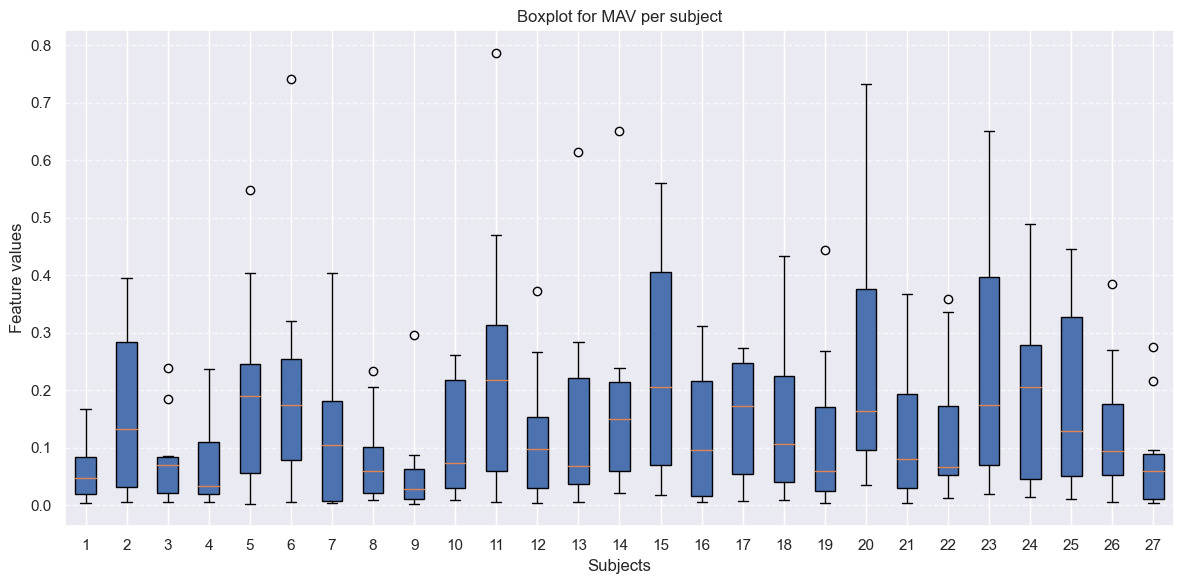

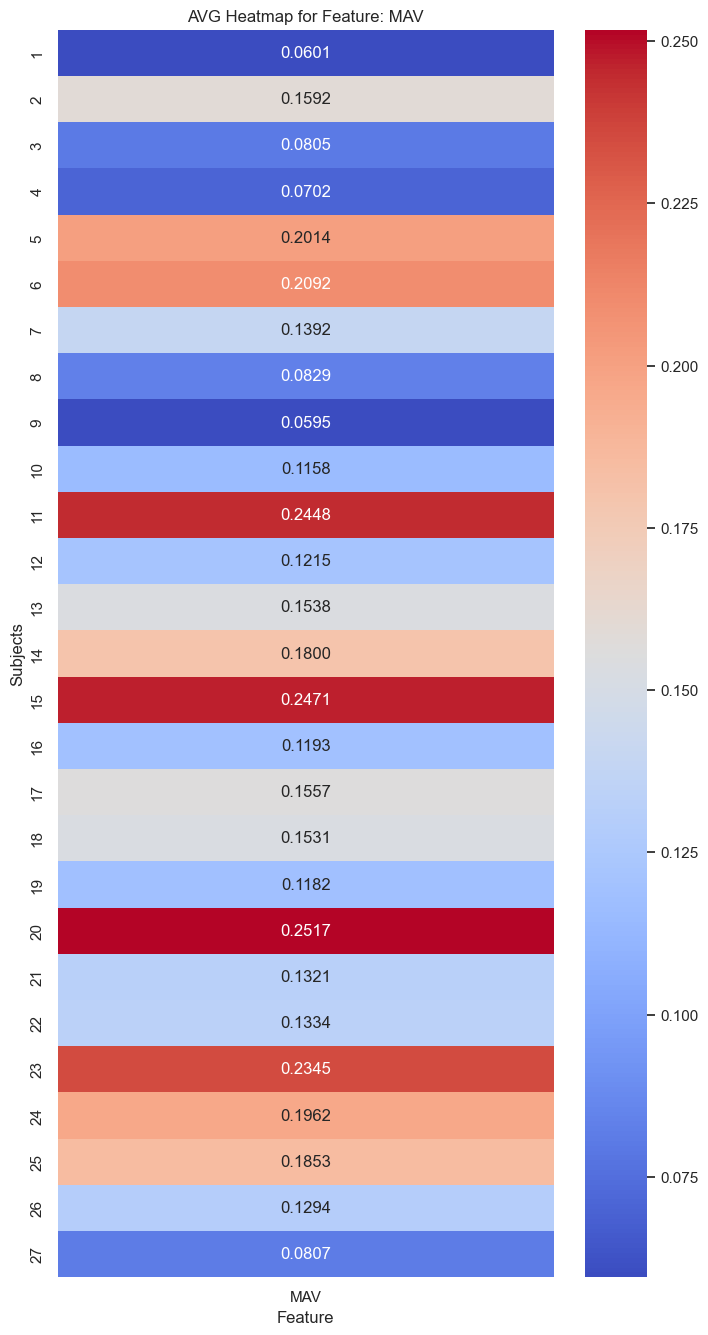

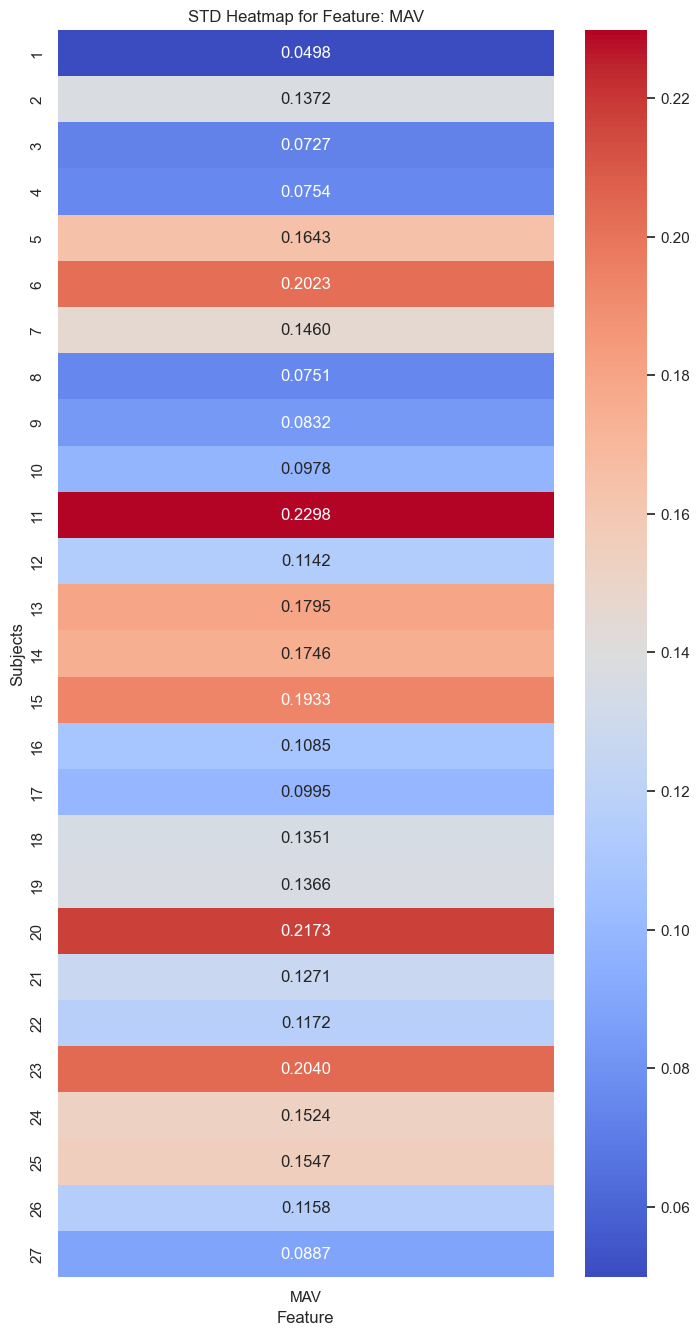

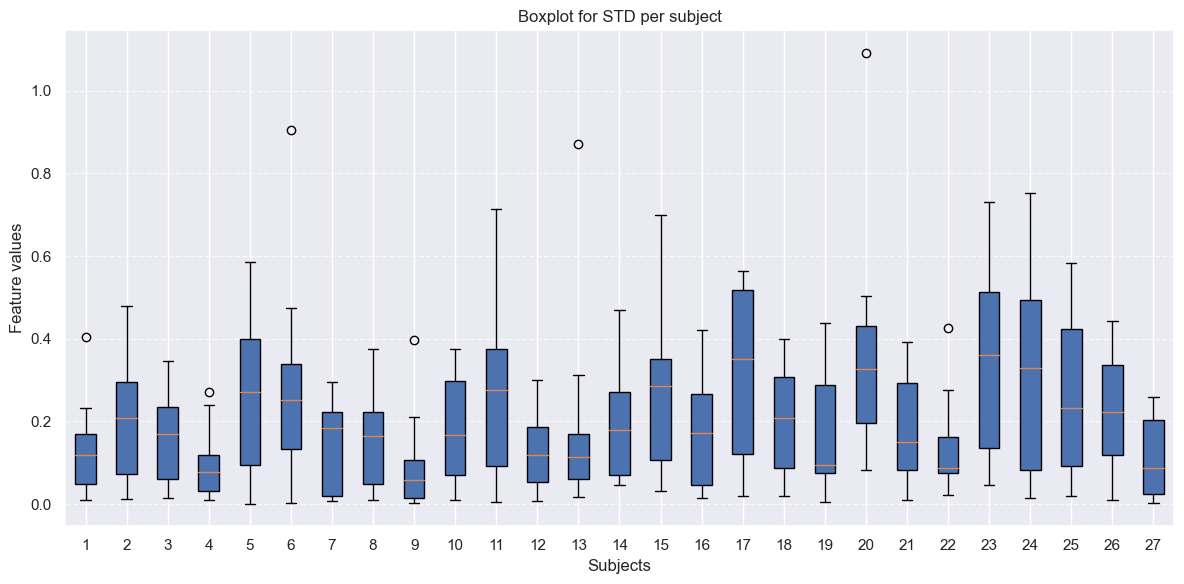

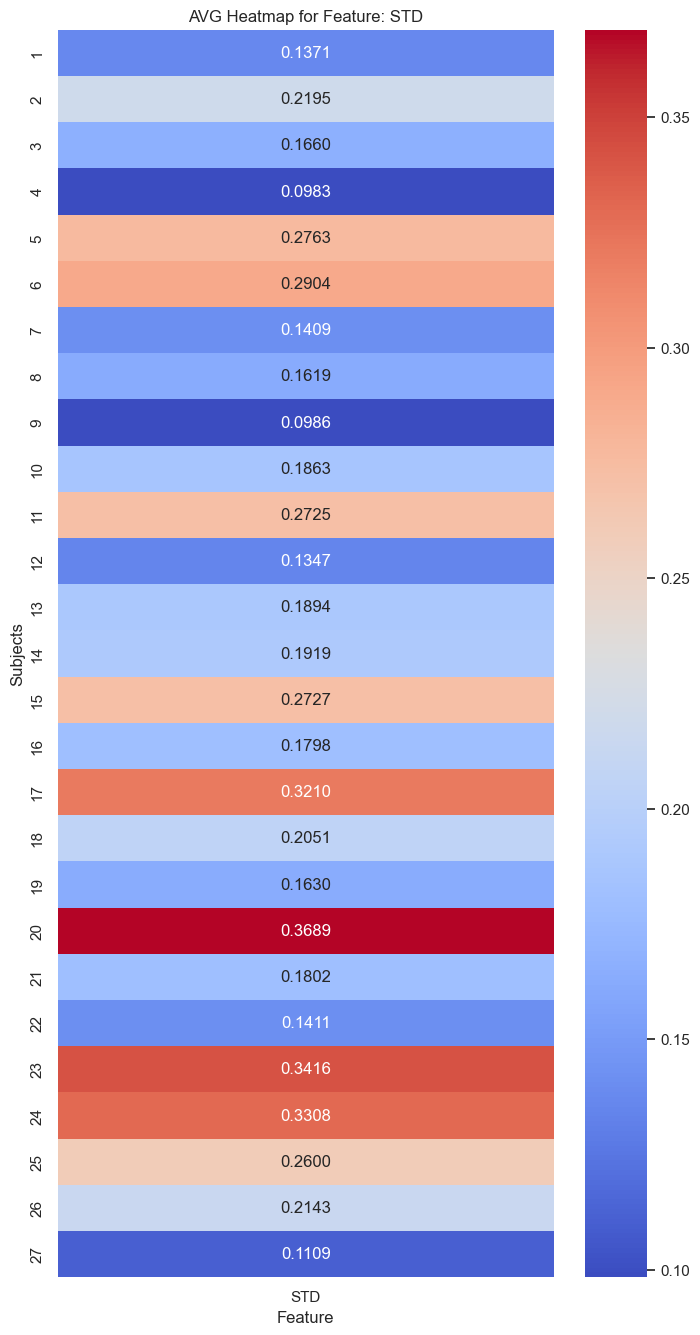

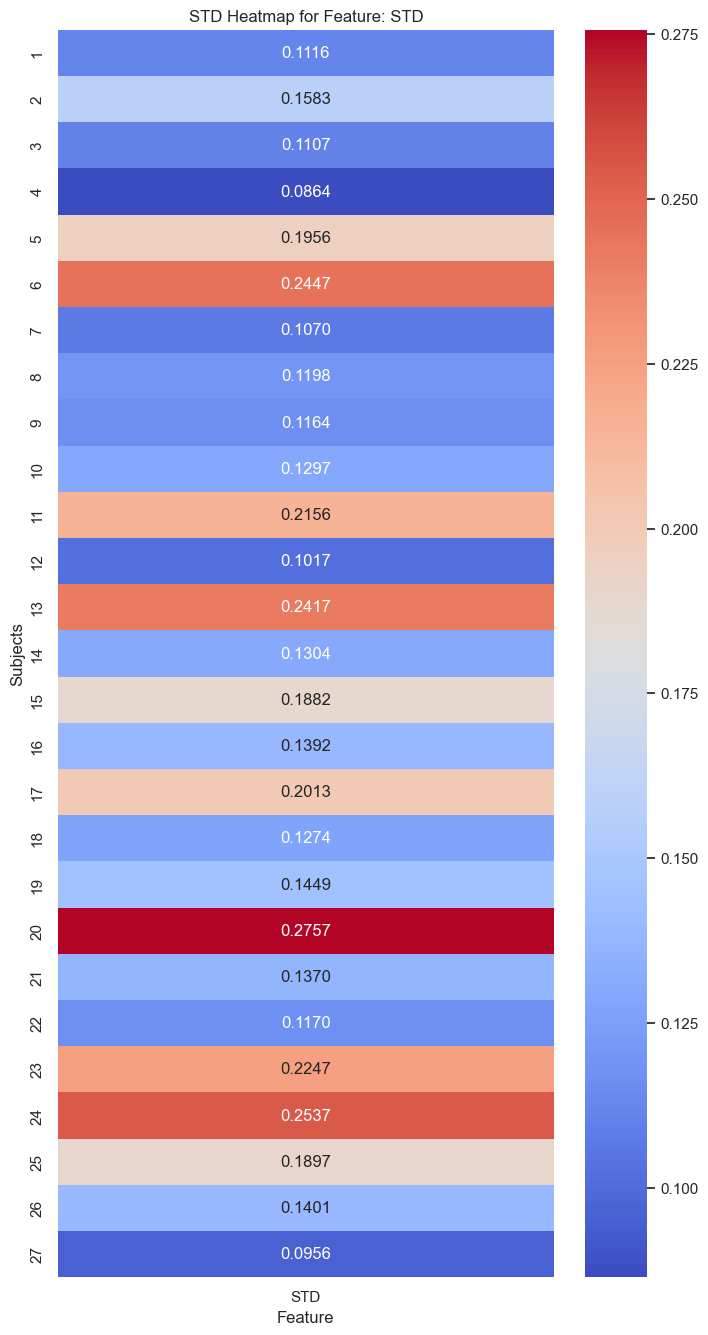

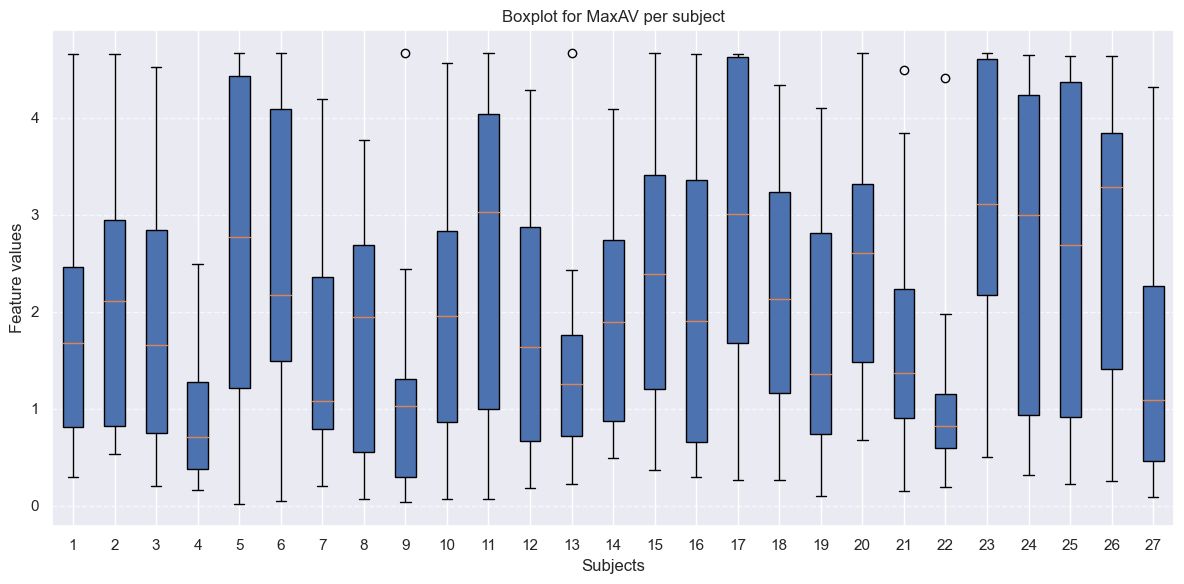

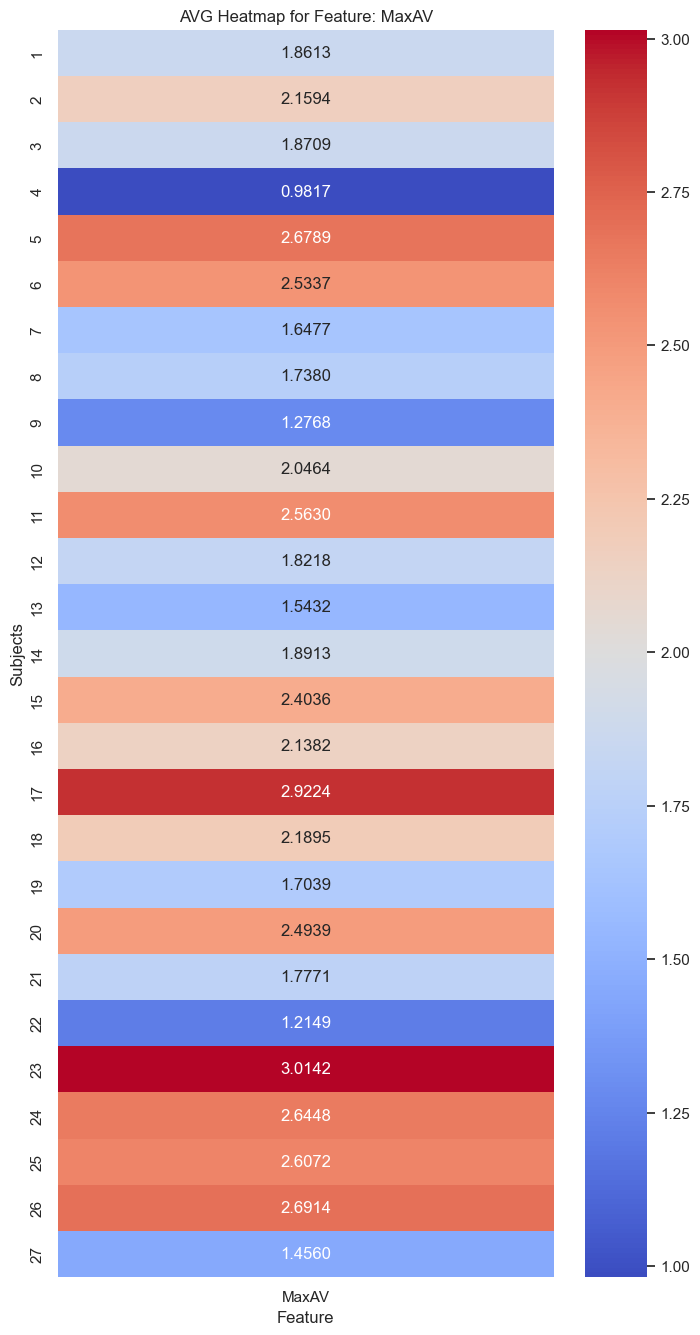

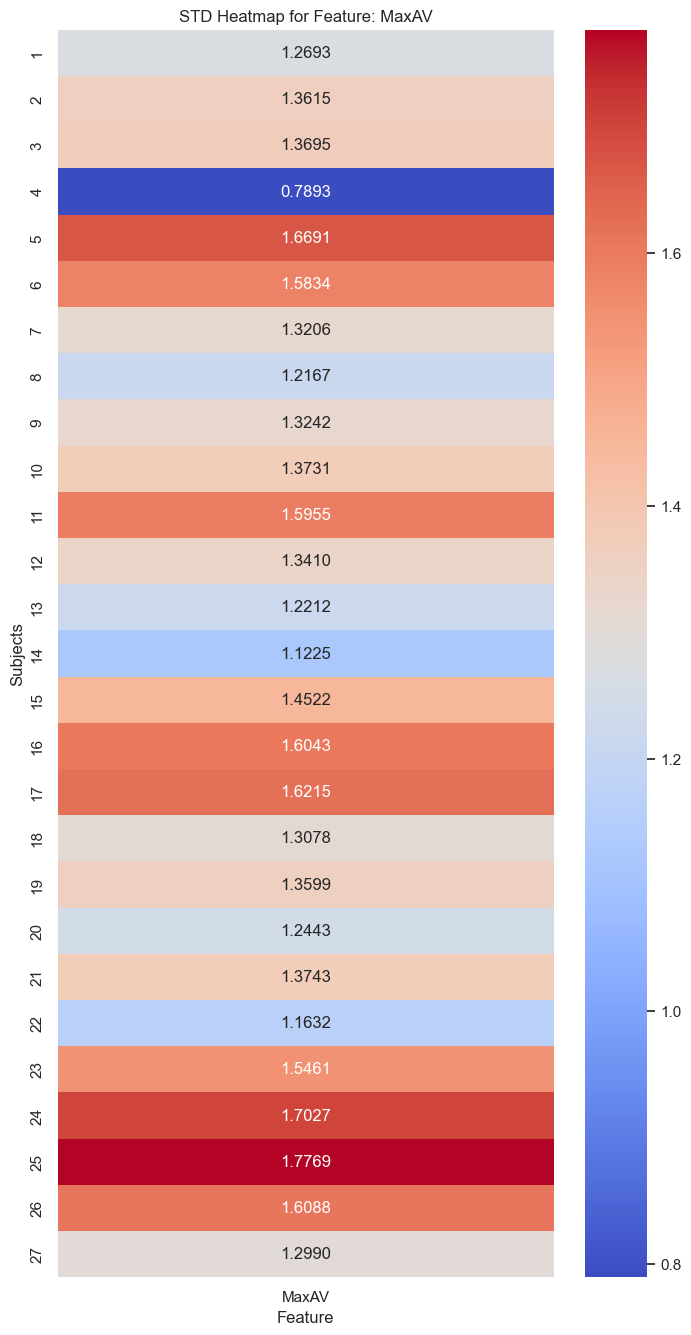

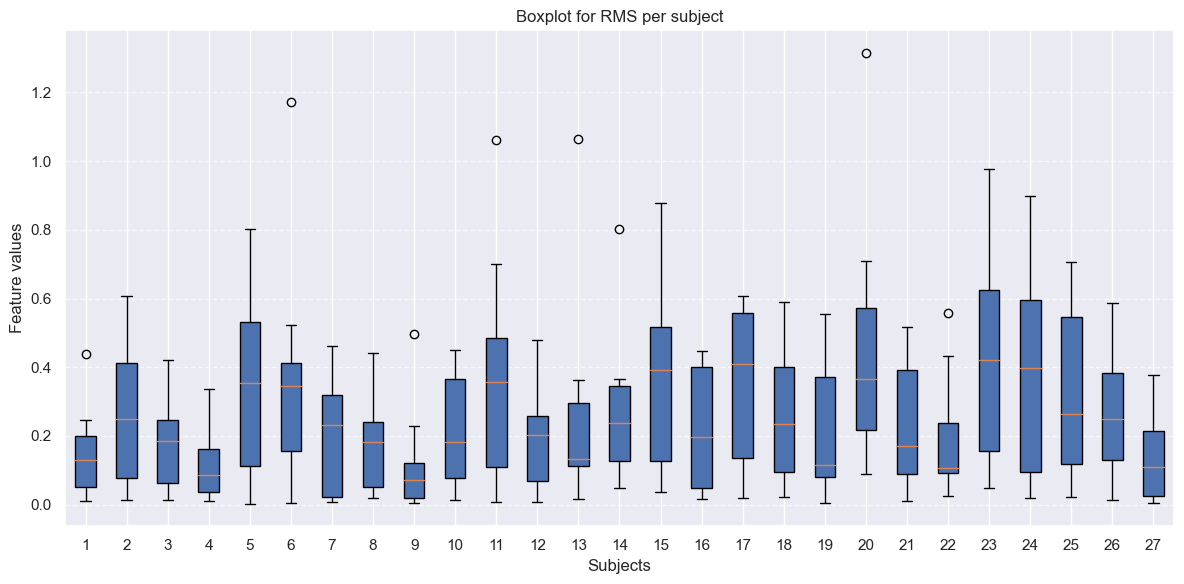

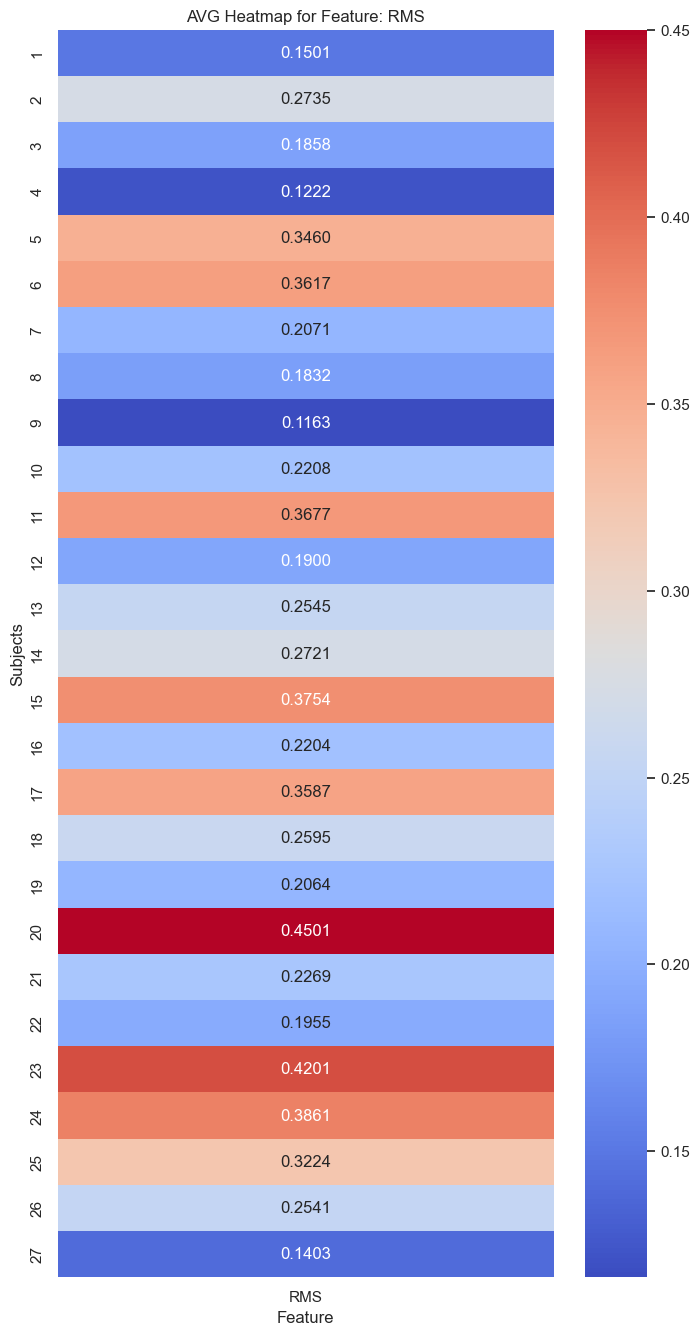

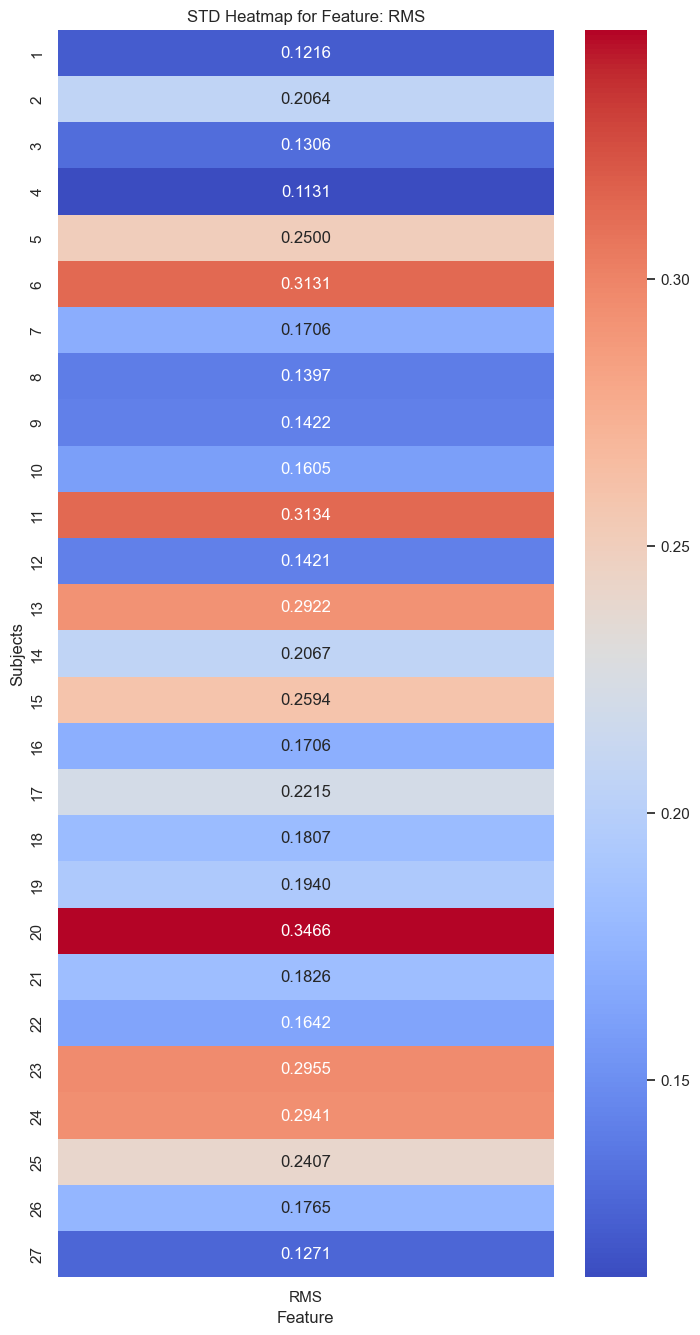

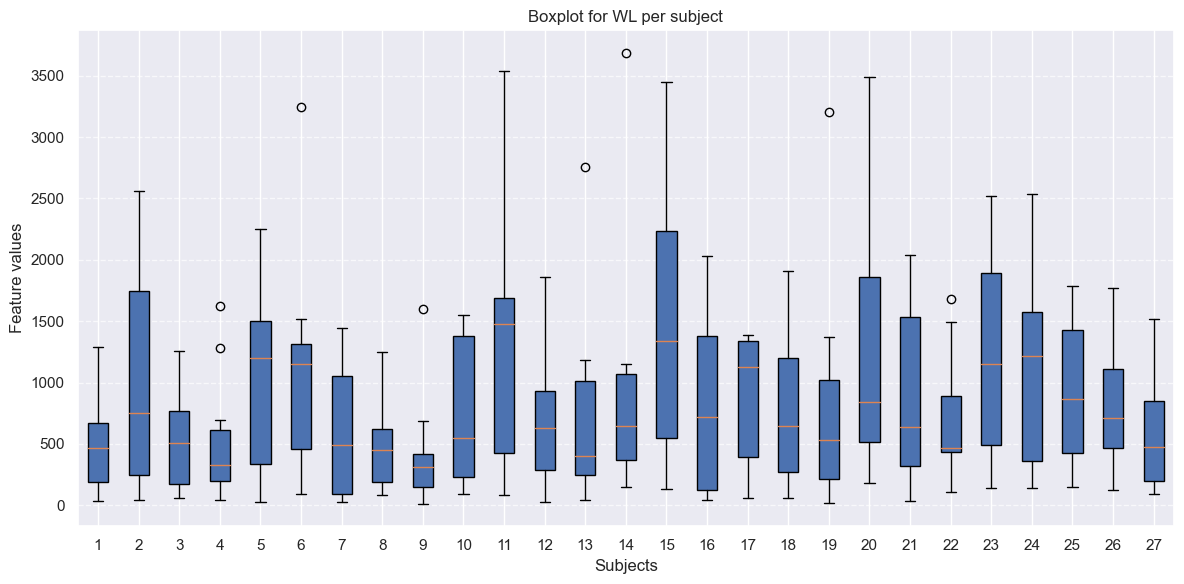

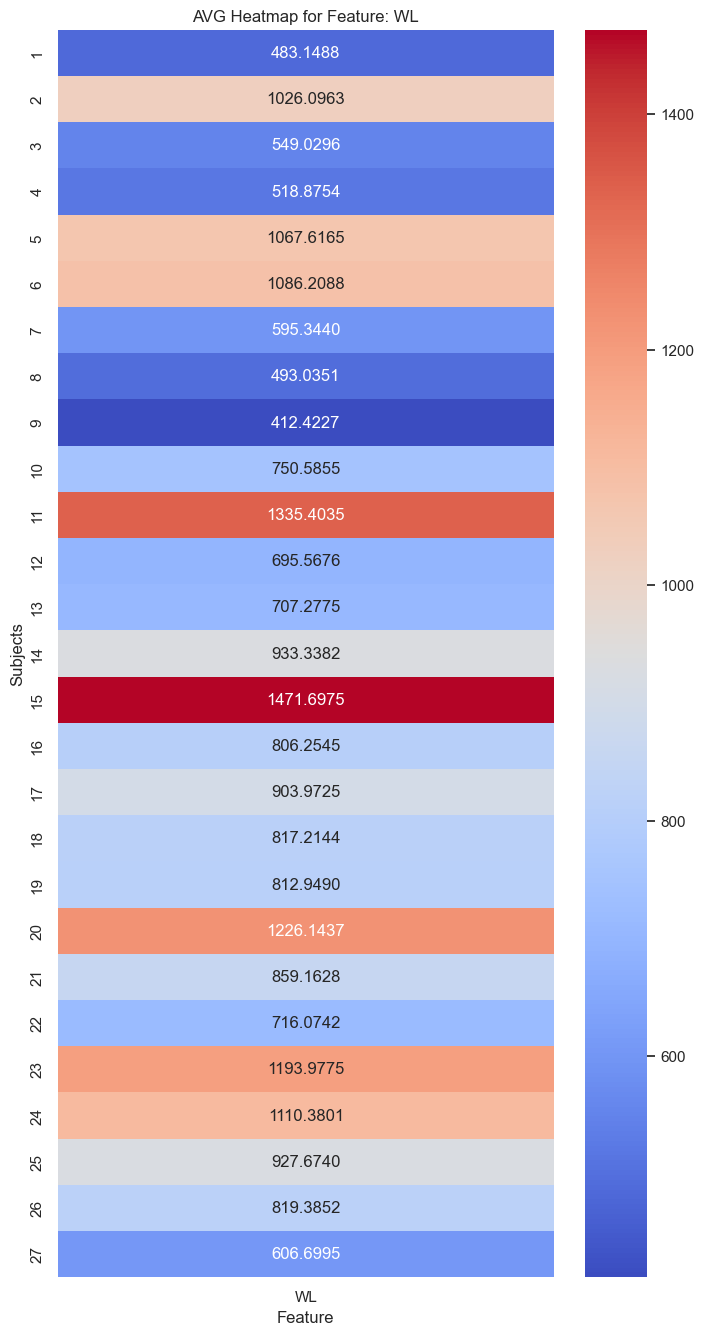

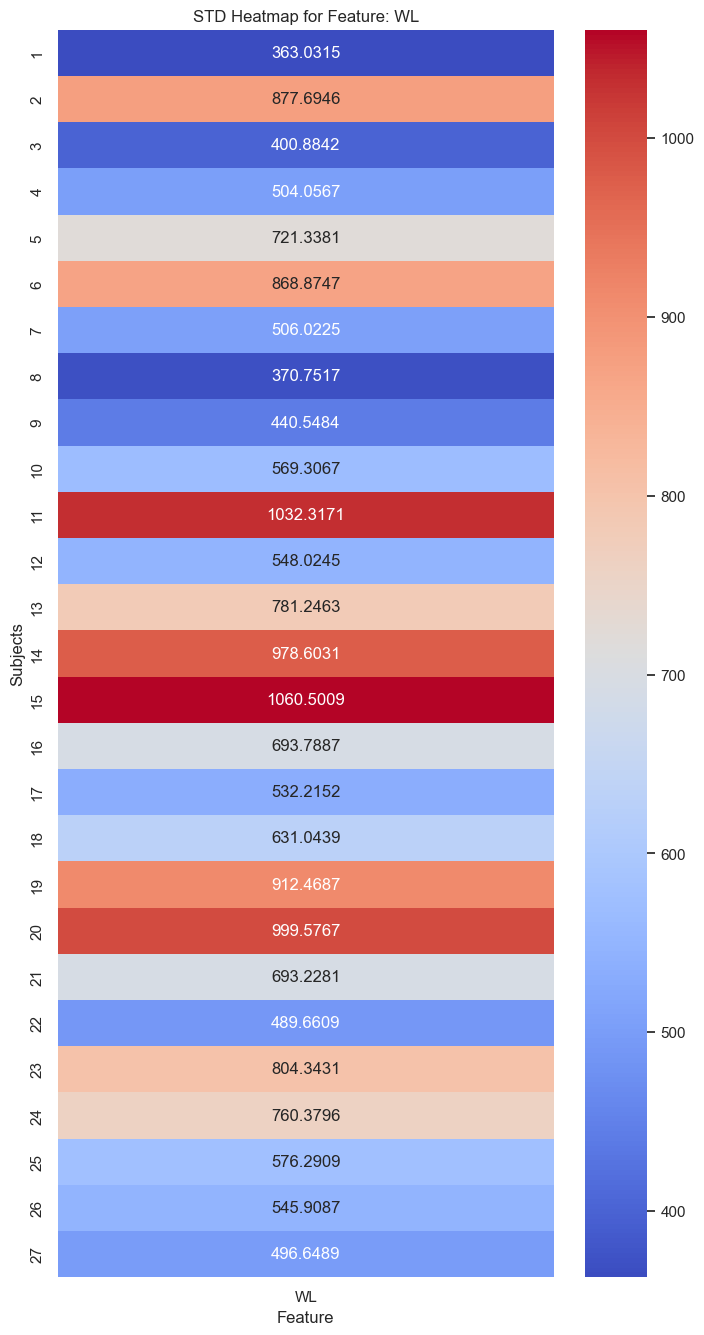

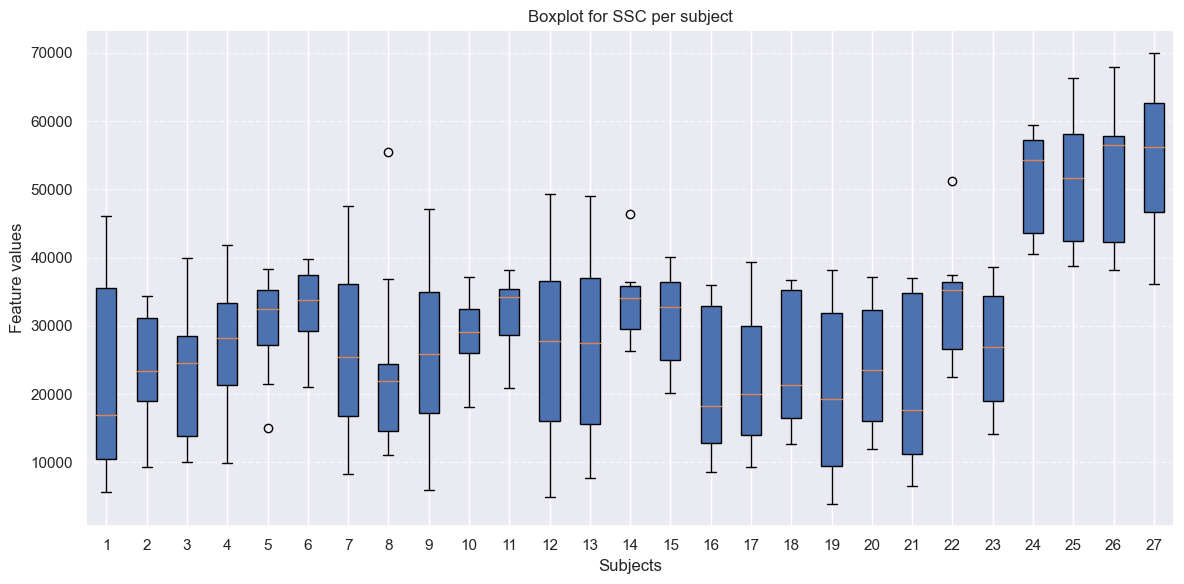

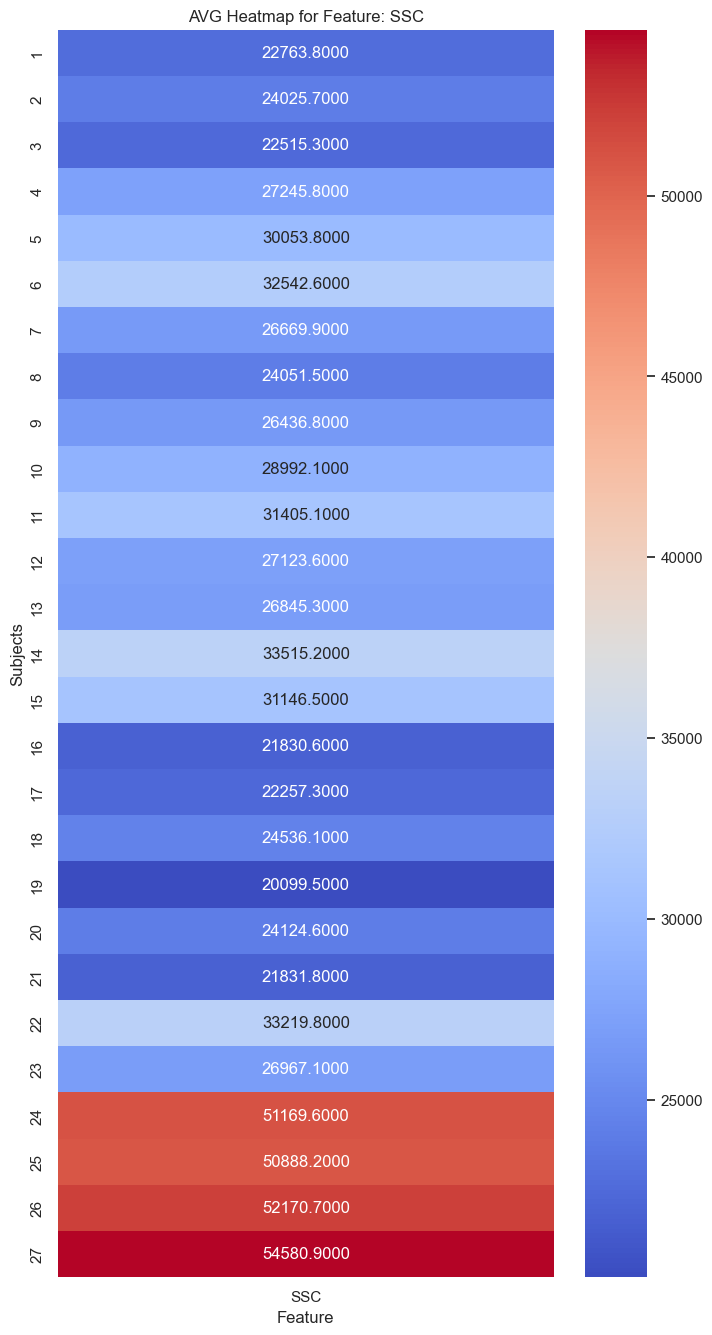

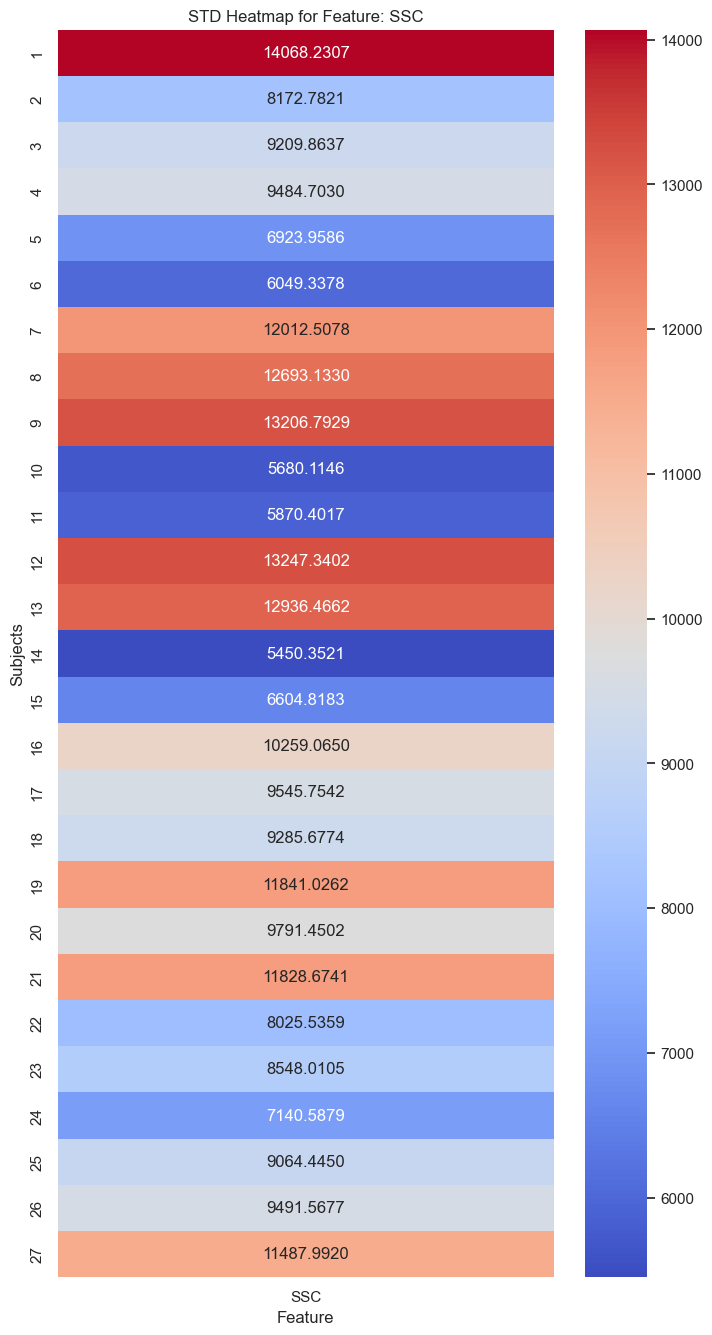

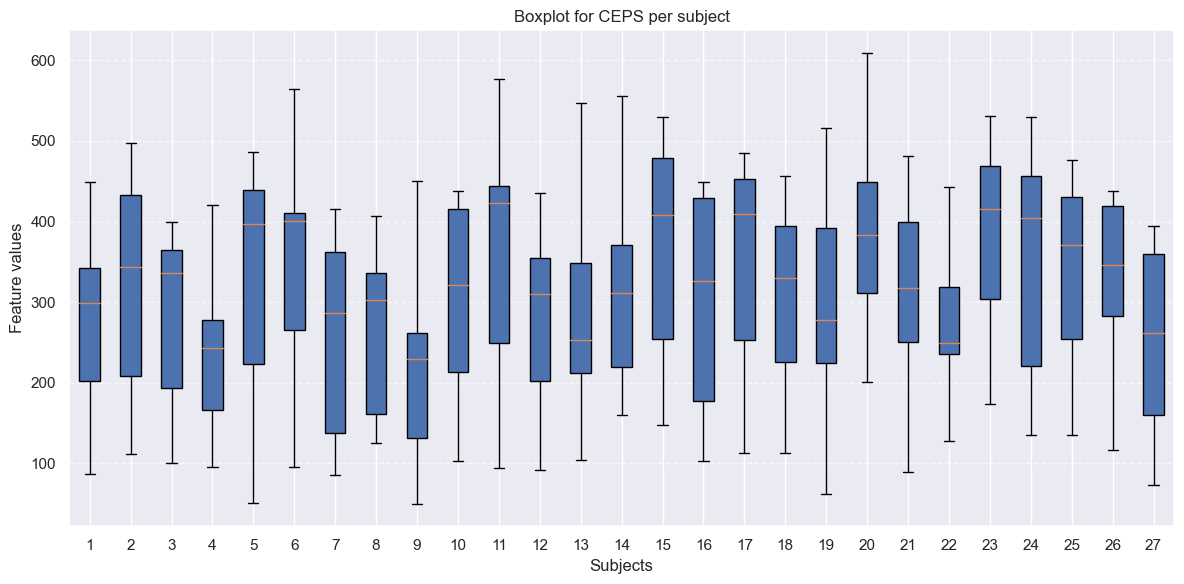

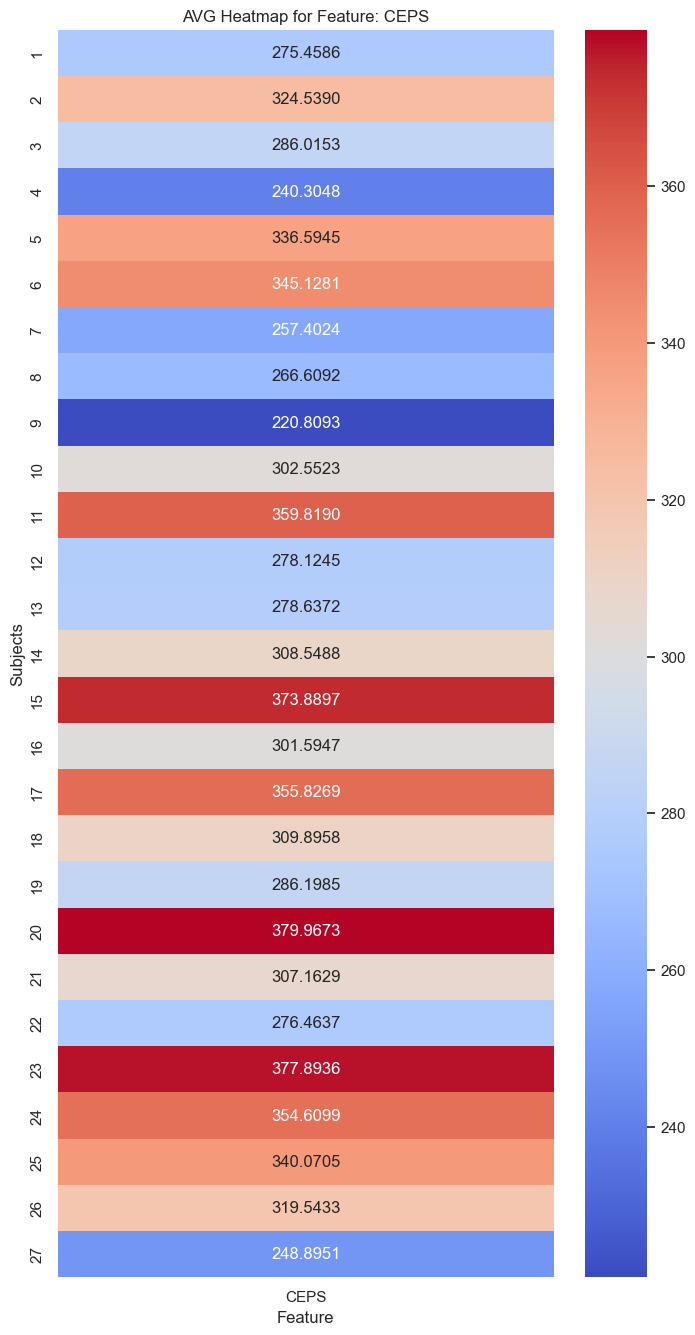

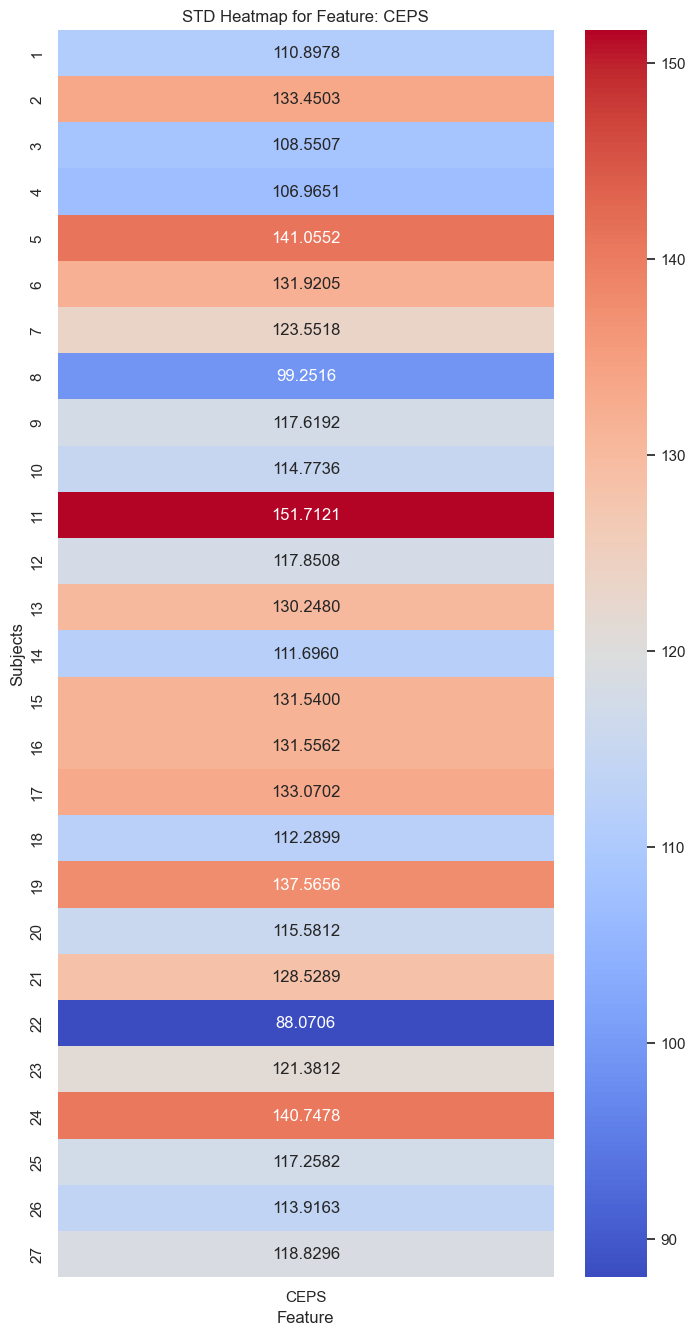

In [20]:
first_subject = next(iter(features))
first_channel = next(iter(features[first_subject]))
feature_labels = list(features[first_subject][first_channel].keys())

# Create heatmaps for each feature (average, std ) and boxplot
for feature in feature_labels:
    feature_data_avg = []  # Rows for the heatmap
    feature_data_std = []
    subject_labels = []  # Y-axis labels
    feature_boxplot = []
    for subject, channels in features.items():
        # Collect the feature values across all channels for this subject
        subject_values = []
        for channel, feature_values in channels.items():
            subject_values.append(feature_values[feature])
        
        avg_feature_value = np.mean(subject_values)
        std_feature_value = np.std(subject_values)
        feature_boxplot.append(subject_values)
        feature_data_avg.append(avg_feature_value)
        feature_data_std.append(std_feature_value)
        subject_labels.append(subject)
    
    plt.figure(figsize=(12, 6))
    plt.boxplot(np.array(feature_boxplot).T, patch_artist=True)

    plt.xlabel('Subjects')
    plt.ylabel('Feature values')
    plt.title(f'Boxplot for {feature} per subject')
    plt.xticks(ticks=np.arange(1, 28), labels=np.arange(1, 28))

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    feature_data = np.array(feature_data_avg).reshape(-1, 1)
    
    plt.figure(figsize=(8, len(subject_labels) * 0.6)) 
    sns.heatmap(
        feature_data,
        annot=True,
        fmt=".4f",
        xticklabels=[feature],
        yticklabels=subject_labels,
        cmap="coolwarm" 
    )
    plt.title(f"AVG Heatmap for Feature: {feature}")
    plt.xlabel("Feature")
    plt.ylabel("Subjects")
    plt.show()

    feature_data = np.array(feature_data_std).reshape(-1, 1)
    
    plt.figure(figsize=(8, len(subject_labels) * 0.6))
    sns.heatmap(
        feature_data,
        annot=True, 
        fmt=".4f",
        xticklabels=[feature], 
        yticklabels=subject_labels, 
        cmap="coolwarm" 
    )
    plt.title(f"STD Heatmap for Feature: {feature}")
    plt.xlabel("Feature")
    plt.ylabel("Subjects")
    plt.show()



agregated_data is a dictionary with the key being the subject number and the value a tuple with 3 data frame (emg,stimulus,repetition)

In [21]:
#create a dictionry emg, stimulus, repetition for 27 subjects
#create a dataset of dimensions 120*27 (trials per subject) x 60
first_run = True
agrg_dataset= {}
for sub,data in agregated_data.items():
    emg,stimulus,repetition = data[0],data[1],data[2]
    dataset, labels = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc]
    )
    agrg_dataset[sub]= (dataset,labels)


3. Train a classification model (same model as part 1) on 26 subjects (aggregating the data) and test it on a subject outside the train set. Evaluate the performance. How does it compare to training and testing on the same subject directly?

There is a significant drop in accuracy

In [22]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [23]:
def split_data(test_subject_ind, dataset):

    first_run = True
    for i in range(1,num_subjects+1):
        if test_subject_ind==i:
            X_test = dataset[i][0]
            y_test = dataset[i][1]
        else:
            if first_run:
                X_train = dataset[i][0]
                y_train = dataset[i][1]
                first_run = False
            else:
                X_train = np.concatenate((X_train,dataset[i][0]), axis=0)
                y_train = np.concatenate((y_train,dataset[i][1]), axis=0)

    return  X_train, X_test, y_train, y_test

In [24]:
def normalize_data(X_train, X_test):
    """One approach could be to normalize the signals, making them more comparable across channels. This normalization would help in identifying specific patterns of muscle activation unique to each stimulus, providing deeper insights into the neuromuscular responses elicited by different stimuli."""
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
    X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler
    return X_train_z, X_test_z

In [25]:
# Train a classifier on the normalized data

def train_model(X_train_z, y_train, X_test_z):
    clf = GradientBoostingClassifier(random_state=42) #using default parameters
    clf.fit(X_train_z, y_train)  # Fit the model on the training data and labels

    # Evaluate the classifier on the test set
    # Predict the labels for the test set
    y_pred = clf.predict(X_test_z)  # Use the 'predict' method to get predicted labels
    return y_pred

def evaluate_model(y_test,y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    return accuracy,f1

In [26]:
test_subject_ind = np.random.randint(27)
X_train, X_test, y_train, y_test = split_data(test_subject_ind+1, agrg_dataset)

In [27]:
X_train_z, X_test_z = normalize_data(X_train, X_test)

Accuracy score: 0.275
F1 score: 0.275


Text(0.5, 20.049999999999997, 'Predicted label')

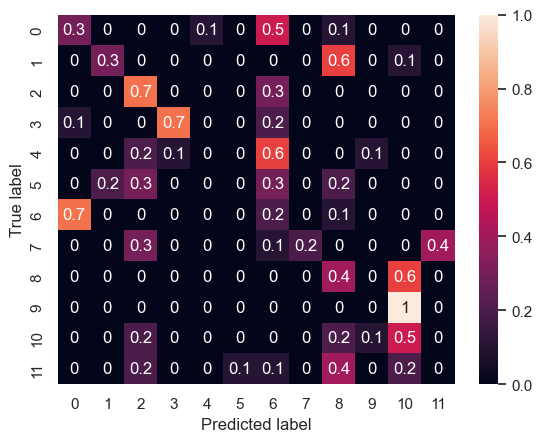

In [28]:
y_pred = train_model(X_train_z, y_train, X_test_z)
accuracy, f1 = evaluate_model(y_test,y_pred)
print(f"Accuracy score: {accuracy}")
print(f"F1 score: {f1}")
# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

4. Perform cross-validation by rotating the subject used for testing. Specifically, for each fold, select one subject as the test set and use the remaining 26 subjects to train the model. Repeat this process for all 27 subjects, ensuring each subject is used as the test set exactly once. Evaluate and compare the performance across all folds to understand how well the model generalizes to new subjects.

In [29]:
scores_acc = []
scores_f1 = []
for i in range(1,num_subjects+1):
    X_train, X_test, y_train, y_test = split_data(i, agrg_dataset)
    X_train_z, X_test_z = normalize_data(X_train, X_test)
    y_pred = train_model(X_train_z, y_train, X_test_z)
    accuracy,f1 = evaluate_model(y_test,y_pred)
    scores_acc.append(accuracy)
    scores_f1.append(f1)
    print(f"Subject {i} is the test, acc: {accuracy}, f1: {f1}")

print(f"Accuracy scores of all models: {scores_acc}")
print(f"Mean accuracy across all models: {np.mean(scores_acc)}")
print(f"F1 scores of all models: {scores_f1}")
print(f"Mean F1 across all models: {np.mean(scores_f1)}")

Subject 1 is the test, acc: 0.3333333333333333, f1: 0.3333333333333333
Subject 2 is the test, acc: 0.125, f1: 0.125
Subject 3 is the test, acc: 0.39166666666666666, f1: 0.39166666666666666
Subject 4 is the test, acc: 0.24166666666666667, f1: 0.24166666666666667
Subject 5 is the test, acc: 0.31666666666666665, f1: 0.31666666666666665
Subject 6 is the test, acc: 0.2833333333333333, f1: 0.2833333333333333
Subject 7 is the test, acc: 0.325, f1: 0.325
Subject 8 is the test, acc: 0.38333333333333336, f1: 0.38333333333333336
Subject 9 is the test, acc: 0.26666666666666666, f1: 0.26666666666666666
Subject 10 is the test, acc: 0.4583333333333333, f1: 0.4583333333333333
Subject 11 is the test, acc: 0.25833333333333336, f1: 0.25833333333333336
Subject 12 is the test, acc: 0.3, f1: 0.3
Subject 13 is the test, acc: 0.3, f1: 0.3
Subject 14 is the test, acc: 0.275, f1: 0.275
Subject 15 is the test, acc: 0.35833333333333334, f1: 0.35833333333333334
Subject 16 is the test, acc: 0.38333333333333336, f1:

In [30]:
test_sub = np.arange(1,28)

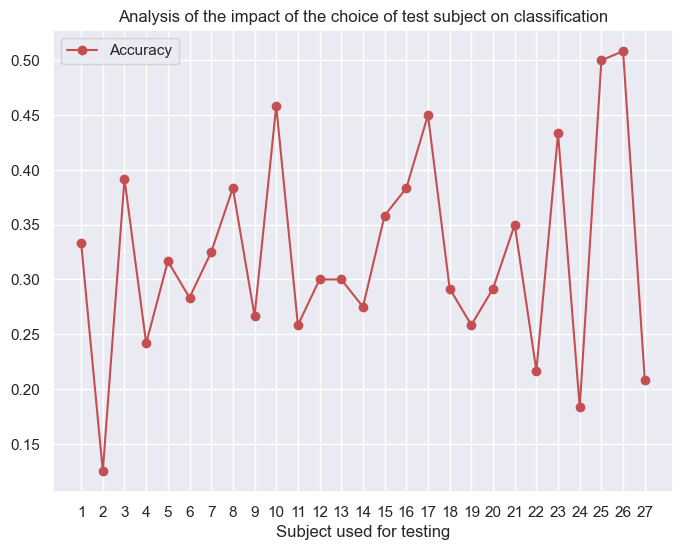

In [31]:
plt.figure(figsize=(8, 6))
plt.plot([str(x) for x in list(test_sub)], scores_acc, marker='o', linestyle='-', color='r', label='Accuracy')

# Add labels and title
plt.xlabel('Subject used for testing')
plt.title('Analysis of the impact of the choice of test subject on classification')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

5. Repeat task 3 by varying the number of subjects in the training set (without performing cross-validation). For example, use subject 27 for testing, and train with subject 1, then train with subjects 1 and 2, then 1, 2, and 3, and continue to increase number of subjects used for training. Analyze how the size of the training set impacts the classification performance on the test subject. Discuss the potential effects of including more or fewer subjects in the training data, focusing on trends in generalization and accuracy.

In [32]:
def split_data_num(num_train, dataset):
   first_run = True
   for i in range(1,num_train+1):
      if first_run:
         X = dataset[i][0]
         y = dataset[i][1]
         first_run = False
      else:
         X = np.concatenate((X,dataset[i][0]), axis=0)
         y = np.concatenate((y,dataset[i][1]), axis=0)
   
   return X, y

In [33]:
scores = {}
#scores key is num_train dataset
test_subject = 27
X_test = agrg_dataset[test_subject][0]
y_test = agrg_dataset[test_subject][1]
for num_train in range(1,num_subjects):
   X_train, y_train = split_data_num(num_train, agrg_dataset)
   print(X_train.shape)
   print(X_test.shape)
   X_train_z, X_test_z = normalize_data(X_train, X_test)
   y_pred = train_model(X_train_z, y_train, X_test_z)
   accuracy,f1 = evaluate_model(y_test,y_pred)
   scores[num_train]=(accuracy,f1)
   print(f"num of subjects in train: {num_train}, accuracy: {accuracy}, f1-score: {f1}")

(120, 60)
(120, 60)
num of subjects in train: 1, accuracy: 0.08333333333333333, f1-score: 0.08333333333333333
(240, 60)
(120, 60)
num of subjects in train: 2, accuracy: 0.15833333333333333, f1-score: 0.15833333333333333
(360, 60)
(120, 60)
num of subjects in train: 3, accuracy: 0.2, f1-score: 0.20000000000000004
(480, 60)
(120, 60)
num of subjects in train: 4, accuracy: 0.13333333333333333, f1-score: 0.13333333333333333
(600, 60)
(120, 60)
num of subjects in train: 5, accuracy: 0.15833333333333333, f1-score: 0.15833333333333333
(720, 60)
(120, 60)
num of subjects in train: 6, accuracy: 0.14166666666666666, f1-score: 0.14166666666666666
(840, 60)
(120, 60)
num of subjects in train: 7, accuracy: 0.15833333333333333, f1-score: 0.15833333333333333
(960, 60)
(120, 60)
num of subjects in train: 8, accuracy: 0.14166666666666666, f1-score: 0.14166666666666666
(1080, 60)
(120, 60)
num of subjects in train: 9, accuracy: 0.16666666666666666, f1-score: 0.16666666666666666
(1200, 60)
(120, 60)
num 

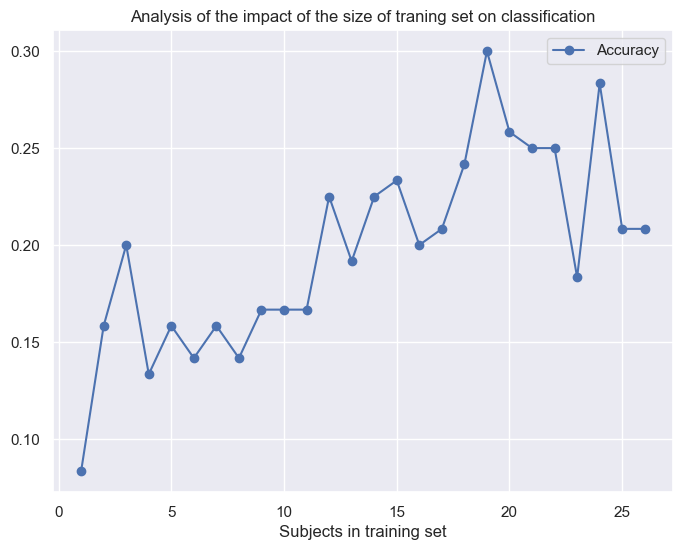

In [34]:
x = list(scores.keys())
acc = [value[0] for value in scores.values()]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(x, acc, marker='o', linestyle='-', color='b', label='Accuracy')

# Add labels and title
plt.xlabel('Subjects in training set')
plt.title('Analysis of the impact of the size of traning set on classification')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()